# <span style='color:gray'> Business Cases with Data Science MDSAA-BA  </span>
### <span style='color:green'> Business Case 4 - 2020/2021 </span>

**GROUP Z:** <br>
- Ana Paulino (20170743) <br>
- Carolina Pina (20170790) <br>
- Soraia Cunha (20170806)

# Implicit feedback recommender system
- https://github.com/benfred/implicit
- https://www.benfrederickson.com/matrix-factorization/
- https://www.ethanrosenthal.com/2016/10/19/implicit-mf-part-1/
- https://kojinoshiba.com/recsys-cold-start/

In [1]:
#pip install --upgrade

In [2]:
#pip install implicit

In [3]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.sparse import coo_matrix
import scipy.sparse as sparse
from implicit.als import AlternatingLeastSquares
from implicit.evaluation import ranking_metrics_at_k
from tqdm import tqdm
from scipy.sparse.linalg import spsolve
import random
from sklearn import metrics
import implicit
from sklearn.preprocessing import MinMaxScaler
import math
import scipy.spatial
import os
from sklearn.cluster import KMeans

# Data Exploration

In [4]:
# Read csv files
df = pd.read_csv('retail.csv')
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 22.7+ MB


In [6]:
df.shape

(541909, 8)

In [7]:
# Percentage of missing values on CustomerID
100-((406829/541909)*100)

24.926694334288598

In [8]:
df.loc[df["UnitPrice"]<0]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
299983,A563186,B,Adjust bad debt,1,8/12/2011 14:51,-11062.06,NaN,United Kingdom
299984,A563187,B,Adjust bad debt,1,8/12/2011 14:52,-11062.06,NaN,United Kingdom


In [9]:
# Replace Missing Values on 'CustomerID' by 'Unknown'
df["CustomerID"].replace(np.nan,"Unknown",inplace=True)


In [10]:
# Replace Missing Values on 'Description' by 'Unknown'
df["Description"].replace(np.nan,"Unknown",inplace=True)

In [11]:
retail=df.copy()
retail.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850,United Kingdom


In [12]:
# Top 10 countries regarding the number of cancellations
retail.loc[retail['Quantity'] <= 0].groupby('Country').count()['InvoiceNo'].nlargest(10)

Country
United Kingdom    9192
Germany            453
EIRE               302
France             149
USA                112
Australia           74
Spain               48
Italy               45
Belgium             38
Japan               37
Name: InvoiceNo, dtype: int64

In [13]:
# Top 10 countries regarding the number of purchases (without cancellations)
retail.loc[retail['Quantity'] > 0].groupby('Country').count()['InvoiceNo'].nlargest(10)

Country
United Kingdom    486286
Germany             9042
France              8408
EIRE                7894
Spain               2485
Netherlands         2363
Belgium             2031
Switzerland         1967
Portugal            1501
Australia           1185
Name: InvoiceNo, dtype: int64

In [14]:
# The number of missing values on CustomerID per each country
retail.loc[retail['CustomerID'].isnull()].groupby('Country').count()['InvoiceNo'].sort_values(ascending = False)

Series([], Name: InvoiceNo, dtype: int64)

In [15]:
C=retail.loc[retail['InvoiceNo'].str.contains('C')]
C

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
141,C536379,D,Discount,-1,12/1/2010 9:41,27.50,14527,United Kingdom
154,C536383,35004C,SET OF 3 COLOURED FLYING DUCKS,-1,12/1/2010 9:49,4.65,15311,United Kingdom
235,C536391,22556,PLASTERS IN TIN CIRCUS PARADE,-12,12/1/2010 10:24,1.65,17548,United Kingdom
236,C536391,21984,PACK OF 12 PINK PAISLEY TISSUES,-24,12/1/2010 10:24,0.29,17548,United Kingdom
237,C536391,21983,PACK OF 12 BLUE PAISLEY TISSUES,-24,12/1/2010 10:24,0.29,17548,United Kingdom
...,...,...,...,...,...,...,...,...
540449,C581490,23144,ZINC T-LIGHT HOLDER STARS SMALL,-11,12/9/2011 9:57,0.83,14397,United Kingdom
541541,C581499,M,Manual,-1,12/9/2011 10:28,224.69,15498,United Kingdom
541715,C581568,21258,VICTORIAN SEWING BOX LARGE,-5,12/9/2011 11:57,10.95,15311,United Kingdom
541716,C581569,84978,HANGING HEART JAR T-LIGHT HOLDER,-1,12/9/2011 11:58,1.25,17315,United Kingdom


In [16]:
C.InvoiceNo.value_counts()

C570867    101
C560540     57
C548460     45
C560855     41
C570828     39
          ... 
C545834      1
C568410      1
C554973      1
C577614      1
C551061      1
Name: InvoiceNo, Length: 3836, dtype: int64

In [17]:
retail.loc[retail['InvoiceNo']=='C570867']

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
393995,C570867,23290,SPACEBOY CHILDRENS BOWL,-8,10/12/2011 16:17,1.25,12607,USA
393996,C570867,23289,DOLLY GIRL CHILDRENS BOWL,-8,10/12/2011 16:17,1.25,12607,USA
393997,C570867,23256,CHILDRENS CUTLERY SPACEBOY,-4,10/12/2011 16:17,4.15,12607,USA
393998,C570867,23255,CHILDRENS CUTLERY CIRCUS PARADE,-4,10/12/2011 16:17,4.15,12607,USA
393999,C570867,23254,CHILDRENS CUTLERY DOLLY GIRL,-4,10/12/2011 16:17,4.15,12607,USA
...,...,...,...,...,...,...,...,...
394091,C570867,23293,SET OF 12 FAIRY CAKE BAKING CASES,-8,10/12/2011 16:17,0.83,12607,USA
394092,C570867,23292,SPACEBOY CHILDRENS CUP,-8,10/12/2011 16:17,1.25,12607,USA
394093,C570867,23291,DOLLY GIRL CHILDRENS CUP,-8,10/12/2011 16:17,1.25,12607,USA
394094,C570867,23513,EMBROIDERED RIBBON REEL SUSIE,-6,10/12/2011 16:17,2.08,12607,USA


In [18]:
# Get df_events and correctly encode the variables
retail['InvoiceDate'] = pd.to_datetime(retail['InvoiceDate'])
retail.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850,United Kingdom


In [19]:
retail.loc[(retail['Quantity']==80995) | (retail['Quantity']==-80995)]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
540421,581483,23843,"PAPER CRAFT , LITTLE BIRDIE",80995,2011-12-09 09:15:00,2.08,16446,United Kingdom
540422,C581484,23843,"PAPER CRAFT , LITTLE BIRDIE",-80995,2011-12-09 09:27:00,2.08,16446,United Kingdom


In [20]:
retail.loc[(retail['CustomerID']==17548.0)]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
235,C536391,22556,PLASTERS IN TIN CIRCUS PARADE,-12,2010-12-01 10:24:00,1.65,17548,United Kingdom
236,C536391,21984,PACK OF 12 PINK PAISLEY TISSUES,-24,2010-12-01 10:24:00,0.29,17548,United Kingdom
237,C536391,21983,PACK OF 12 BLUE PAISLEY TISSUES,-24,2010-12-01 10:24:00,0.29,17548,United Kingdom
238,C536391,21980,PACK OF 12 RED RETROSPOT TISSUES,-24,2010-12-01 10:24:00,0.29,17548,United Kingdom
239,C536391,21484,CHICK GREY HOT WATER BOTTLE,-12,2010-12-01 10:24:00,3.45,17548,United Kingdom
240,C536391,22557,PLASTERS IN TIN VINTAGE PAISLEY,-12,2010-12-01 10:24:00,1.65,17548,United Kingdom
241,C536391,22553,PLASTERS IN TIN SKULLS,-24,2010-12-01 10:24:00,1.65,17548,United Kingdom
165024,550755,22585,PACK OF 6 BIRDY GIFT TAGS,24,2011-04-20 12:01:00,1.25,17548,United Kingdom
165025,550755,22082,RIBBON REEL STRIPES DESIGN,10,2011-04-20 12:01:00,1.65,17548,United Kingdom
165026,550755,22081,RIBBON REEL FLORA + FAUNA,10,2011-04-20 12:01:00,1.65,17548,United Kingdom


In [21]:
retail.loc[retail["UnitPrice"]<=0]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
622,536414,22139,Unknown,56,2010-12-01 11:52:00,0.0,Unknown,United Kingdom
1970,536545,21134,Unknown,1,2010-12-01 14:32:00,0.0,Unknown,United Kingdom
1971,536546,22145,Unknown,1,2010-12-01 14:33:00,0.0,Unknown,United Kingdom
1972,536547,37509,Unknown,1,2010-12-01 14:33:00,0.0,Unknown,United Kingdom
1987,536549,85226A,Unknown,1,2010-12-01 14:34:00,0.0,Unknown,United Kingdom
...,...,...,...,...,...,...,...,...
536981,581234,72817,Unknown,27,2011-12-08 10:33:00,0.0,Unknown,United Kingdom
538504,581406,46000M,POLYESTER FILLER PAD 45x45cm,240,2011-12-08 13:58:00,0.0,Unknown,United Kingdom
538505,581406,46000S,POLYESTER FILLER PAD 40x40cm,300,2011-12-08 13:58:00,0.0,Unknown,United Kingdom
538554,581408,85175,Unknown,20,2011-12-08 14:06:00,0.0,Unknown,United Kingdom


In [22]:
auxUnitPrice = retail.loc[retail['UnitPrice']==0][['Description', 'Quantity', 'Country']]
auxUnitPrice.head(10)

,Description,Quantity,Country
622,Unknown,56,United Kingdom
1970,Unknown,1,United Kingdom
1971,Unknown,1,United Kingdom
1972,Unknown,1,United Kingdom
1987,Unknown,1,United Kingdom
1988,Unknown,1,United Kingdom
2024,Unknown,1,United Kingdom
2025,Unknown,3,United Kingdom
2026,Unknown,23,United Kingdom
2406,Unknown,-10,United Kingdom


In [23]:
auxUnitPrice['Description'].unique()

array(['Unknown', 'amazon', '?', 'ROUND CAKE TIN VINTAGE GREEN', 'check',
       'damages', 'CREAM SWEETHEART LETTER RACK',
       'ZINC WILLIE WINKIE  CANDLE STICK', 'BOX OF 24 COCKTAIL PARASOLS',
       'DOORMAT ENGLISH ROSE ', 'DOORMAT 3 SMILEY CATS',
       'GREEN REGENCY TEACUP AND SAUCER', 'FRENCH BLUE METAL DOOR SIGN 7',
       'FRENCH BLUE METAL DOOR SIGN 5', 'FRENCH BLUE METAL DOOR SIGN 6',
       'FRENCH BLUE METAL DOOR SIGN 4', 'FRENCH BLUE METAL DOOR SIGN No',
       'FRENCH BLUE METAL DOOR SIGN 8', 'FRENCH BLUE METAL DOOR SIGN 1',
       'RED KITCHEN SCALES', 'IVORY KITCHEN SCALES',
       'SET OF 6 SOLDIER SKITTLES', 'CHILDS GARDEN TROWEL BLUE ',
       'CHILDRENS GARDEN GLOVES BLUE', 'PICNIC BASKET WICKER SMALL',
       'PICNIC BASKET WICKER LARGE', 'EMPIRE UNION JACK TV DINNER TRAY',
       'TV DINNER TRAY VINTAGE PAISLEY', 'SPACEBOY TV DINNER TRAY',
       'TV DINNER TRAY DOLLY GIRL', 'CHILDS GARDEN SPADE BLUE',
       'CHILDS GARDEN RAKE BLUE', 'WATERING CAN PINK BUNN

<span style='color:red'> **NOTE:** </span> <br>
We detected that there are some plausible reasons for UnitPrice being equal to zero when looking at the Descriptions of such products (e.g. "broken", "damages", "wrong code?", "MIA", "Sale error", etc); however, for this part of Data Understanding, descriptive statistics, we will keep these records as there are many records who have indeed real names of items, when building the recommender system we will then remove all the records with UnitPrice equal to zero as there are still many descriptions that don't fit with products to be recommended.

In [24]:
auxUnitPrice['Quantity'].unique()

array([   56,     1,     3,    23,   -10,   -38,    19,    20,    15,
          57,   -20,    -6,   110,   -22,    70,    -2,   -30,   -70,
        -130,   -80,  -120,   -40,    -5,   -12,   -25,   -14,   -15,
         -69,    -3,  -140,  -320,     5,   -24,   -35,   -21,   120,
         -43,     7,    10,    13,   -19,   -11,   -18,   -44,   -50,
           2,    29,    30,    -9,   -77,  -223,   144,    34,     8,
          -4,    -1,    27,  -150,   -13,  -723,  -177,    46,    79,
          84,     9,   -32,   288,  -100,   -28,  -145,    25,   460,
           4,    12,   752,    36,    53,     6,   -36,   -48,  -106,
         -60,  -939,    35,   -54,  -201,    24,   -53,   -29, -2600,
        -990,    -8,  -290,    26,    40,   -45,  1000,  -310,   -61,
         -41,   -64,   -84, -1400,  -300,   -57,   -59,   -16,   192,
         -31,    65,   -17,  5568,  2560,   136,  -207,   -52,  -206,
         320,   960,    60,  -217,    18, -1430,  1287,  -162,  -230,
        -173,  -390,

In [25]:
auxUnitPrice['Country'].unique()

array(['United Kingdom', 'Germany', 'EIRE', 'Switzerland', 'Australia',
       'Spain', 'Netherlands', 'RSA', 'France', 'Norway'], dtype=object)

In [26]:
# Describe dataset
retail.describe(include='all').T

,count,unique,top,freq,first,last,mean,std,min,25%,50%,75%,max
InvoiceNo,541909,25900,573585,1114,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
StockCode,541909,4070,85123A,2313,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Description,541909,4224,WHITE HANGING HEART T-LIGHT HOLDER,2369,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Quantity,541909,NaN,NaN,NaN,NaT,NaT,9.55225,218.081,-80995,1,3,10,80995
InvoiceDate,541909,23260,2011-10-31 14:41:00,1114,2010-12-01 08:26:00,2011-12-09 12:50:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
UnitPrice,541909,NaN,NaN,NaN,NaT,NaT,4.61111,96.7599,-11062.1,1.25,2.08,4.13,38970
CustomerID,541909,4373,Unknown,135080,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Country,541909,38,United Kingdom,495478,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Divide the dataset into no cancellations and cancellations

In [27]:
new_customers=retail.loc[retail["CustomerID"]=="Unknown"]
retail=retail.loc[retail["CustomerID"]!="Unknown"]

In [28]:
retail_nc = retail.loc[retail["Quantity"]>=0]
cancellations = retail.loc[retail["Quantity"]<0]

### Visualizations

In [29]:
retail_nc["InvoiceNo"].value_counts()

576339    542
579196    533
580727    529
578270    442
573576    435
         ... 
575582      1
564047      1
550345      1
560413      1
573121      1
Name: InvoiceNo, Length: 18536, dtype: int64

In [30]:
retail_nc["CustomerID"].value_counts()

17841.0    7847
14911.0    5677
14096.0    5111
12748.0    4596
14606.0    2700
           ... 
15524.0       1
15562.0       1
15657.0       1
15668.0       1
12346.0       1
Name: CustomerID, Length: 4339, dtype: int64

Text(0, 0.5, 'Total number of orders')

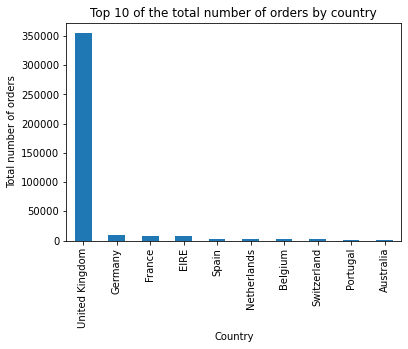

In [31]:
# Get the top 10 of the total number of orders by country
retail_nc.groupby("Country").count()["CustomerID"].nlargest(10).plot(kind='bar')
plt.title('Top 10 of the total number of orders by country')
plt.ylabel('Total number of orders')

In [32]:
# Create a dataframe with only 'InvoiceNo' and 'Country' in order to get the unique invoice numbers per each country
Invoices=retail_nc[['InvoiceNo','Country']]
Invoices=Invoices.drop_duplicates()

In [33]:
# Total number of invoices by each country
totalinvoicesbycountry=pd.DataFrame(Invoices.groupby("Country").count()["InvoiceNo"].sort_values(ascending=False))
totalinvoicesbycountry

,InvoiceNo
Country,
United Kingdom,16649
Germany,457
France,389
EIRE,260
Belgium,98
Netherlands,95
Spain,90
Australia,57
Portugal,57


In [34]:
# Create a dataframe with only 'CustomerID' and 'Country' in order to get the unique customers per each country
Customers=retail_nc[['CustomerID','Country']]
Customers=Customers.drop_duplicates()
Customers

,CustomerID,Country
0,17850,United Kingdom
9,13047,United Kingdom
26,12583,France
46,13748,United Kingdom
65,15100,United Kingdom
...,...,...
536969,13436,United Kingdom
537255,15520,United Kingdom
538064,13298,United Kingdom
538812,14569,United Kingdom


In [35]:
# Total number of orders by each country
totalordersbycountry = pd.DataFrame(Customers.groupby("Country").count()["CustomerID"].sort_values(ascending=False))
totalordersbycountry

,CustomerID
Country,
United Kingdom,3921
Germany,94
France,87
Spain,30
Belgium,25
Switzerland,21
Portugal,19
Italy,14
Finland,12


Text(0, 0.5, 'Total number of orders')

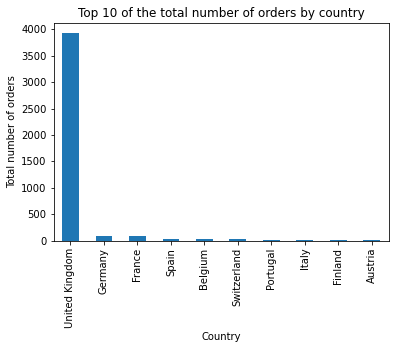

In [36]:
# Get the Top 10 of the total number of orders by country
Customers.groupby("Country").count()["CustomerID"].nlargest(10).plot(kind='bar')
plt.title('Top 10 of the total number of orders by country')
plt.ylabel('Total number of orders')

Text(0.5, 1.0, 'Top 10 countries regarding the number of cancellations')

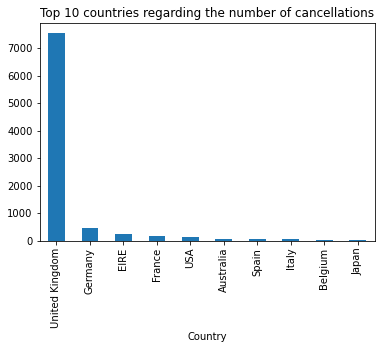

In [37]:
# Top 10 countries regarding the number of cancellations
cancellations.groupby('Country').count()['InvoiceNo'].nlargest(10).plot(kind='bar')
plt.title("Top 10 countries regarding the number of cancellations")

In [38]:
# Get the unique pairs of 'CustomerID' & 'InvoiceNo'
CI=retail_nc[['CustomerID','InvoiceNo']].drop_duplicates()
CI

,CustomerID,InvoiceNo
0,17850,536365
7,17850,536366
9,13047,536367
21,13047,536368
25,13047,536369
...,...,...
541865,13777,581583
541867,13777,581584
541869,15804,581585
541890,13113,581586


In [39]:
# Total number of unique orders by each customer
totalinvoicesbycustomer = pd.DataFrame(CI.groupby("CustomerID").count()["InvoiceNo"].sort_values(ascending=False))
totalinvoicesbycustomer

,InvoiceNo
CustomerID,
12748.0,210
14911.0,201
17841.0,124
13089.0,97
14606.0,93
...,...
13845.0,1
17253.0,1
16302.0,1


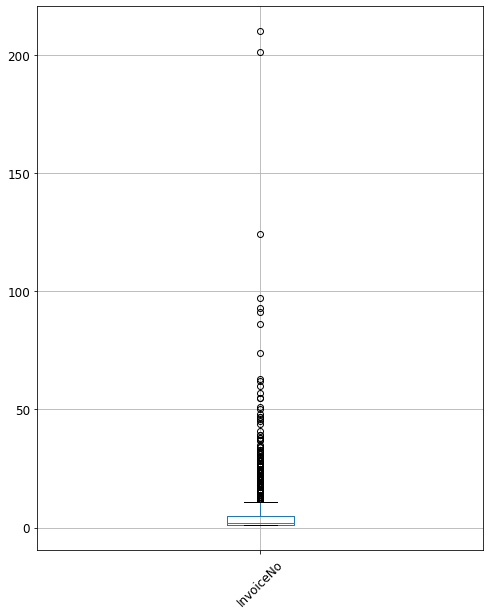

In [40]:
# Distribution of the total number of invoices by each customer
totalinvoicesbycustomer.boxplot(rot=45, fontsize=12, figsize=(8,10))

In [41]:
totalinvoicesbycustomer.describe(include='all')

,InvoiceNo
count,4339.000000
mean,4.271952
std,7.705493
min,1.000000
25%,1.000000
50%,2.000000
75%,5.000000
max,210.000000


In [42]:
# Total purchases by each CustomerID
totalpurchasesbycustomer = pd.DataFrame(retail_nc.groupby("CustomerID").count()["InvoiceNo"].sort_values(ascending=False))
totalpurchasesbycustomer

,InvoiceNo
CustomerID,
17841.0,7847
14911.0,5677
14096.0,5111
12748.0,4596
14606.0,2700
...,...
15524.0,1
15562.0,1
15657.0,1


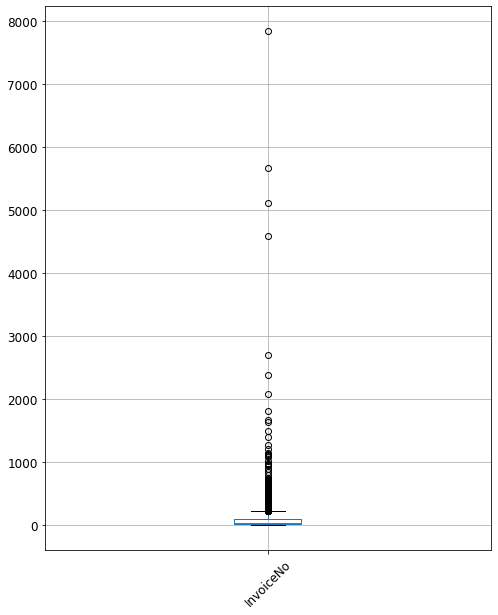

In [43]:
# Distribution of purchases by each customer
totalpurchasesbycustomer.boxplot(rot=45, fontsize=12, figsize=(8,10))

In [44]:
# The result obtained in the 25% quantile represents the value to use in uid_min threshold_ratings reduce sparsity function
totalpurchasesbycustomer.describe(include='all')

,InvoiceNo
count,4339.000000
mean,91.708689
std,228.792852
min,1.000000
25%,17.000000
50%,41.000000
75%,100.000000
max,7847.000000


In [45]:
# Total number of invoices by each product description
totalinvoicesbyproduct = pd.DataFrame(retail_nc.groupby(["Description",'StockCode']).count()["InvoiceNo"].sort_values(ascending=False))
totalinvoicesbyproduct

,,InvoiceNo
Description,StockCode,
WHITE HANGING HEART T-LIGHT HOLDER,85123A,2028
REGENCY CAKESTAND 3 TIER,22423,1724
JUMBO BAG RED RETROSPOT,85099B,1618
ASSORTED COLOUR BIRD ORNAMENT,84879,1408
PARTY BUNTING,47566,1397
...,...,...
"CAKESTAND, 3 TIER, LOVEHEART",22776,1
PINK FLOCK PHOTO FRAME,84705C,1
MINT DINER CLOCK,23342,1


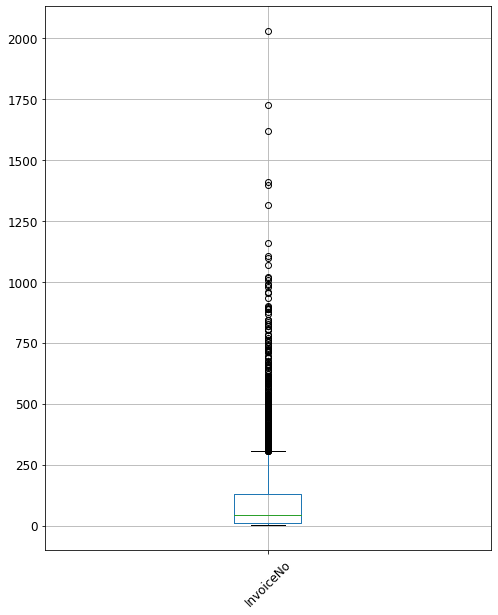

In [46]:
# Distribution of the total number of invoices by each product description
totalinvoicesbyproduct.boxplot(rot=45, fontsize=12, figsize=(8,10))

In [47]:
# The result obtained in the 25% quantile represents the value to use in iid_min threshold_ratings reduce sparsity function
totalinvoicesbyproduct.describe(include='all')

,InvoiceNo
count,3897.000000
mean,102.110341
std,157.901953
min,1.000000
25%,10.000000
50%,43.000000
75%,128.000000
max,2028.000000


In [48]:
# Total number of ordered products according to their description 
totalquantitybyproduct = pd.DataFrame(retail_nc.groupby(["Description",'StockCode']).sum()["Quantity"].sort_values(ascending=False))
totalquantitybyproduct

,,Quantity
Description,StockCode,
"PAPER CRAFT , LITTLE BIRDIE",23843,80995
MEDIUM CERAMIC TOP STORAGE JAR,23166,77916
WORLD WAR 2 GLIDERS ASSTD DESIGNS,84077,54415
JUMBO BAG RED RETROSPOT,85099B,46181
WHITE HANGING HEART T-LIGHT HOLDER,85123A,36725
...,...,...
BLUE NEW BAROQUE FLOCK CANDLESTICK,84613C,1
AMBER GLASS/SHELL/PEARL NECKLACE,90181A,1
BLUE PADDED SOFT MOBILE,20703,1


In [49]:
# Average quantity of all orders of each product
avgquantitybyproduct = pd.DataFrame(retail_nc.groupby(["Description",'StockCode']).mean()["Quantity"].sort_values(ascending=False).round(3))
avgquantitybyproduct

# Note: 'PAPER CRAFT , LITTLE BIRDIE' was ordered only in one invoice for the quantity of 80995

,,Quantity
Description,StockCode,
"PAPER CRAFT , LITTLE BIRDIE",23843,80995.000
TEA TIME TEA TOWELS,47556B,1300.000
GIRLS ALPHABET IRON ON PATCHES,84568,520.000
MEDIUM CERAMIC TOP STORAGE JAR,23166,393.515
ASSTD DESIGN 3D PAPER STICKERS,84826,380.611
...,...,...
DOLPHIN WINDMILL,77079,1.000
CAPIZ CHANDELIER,21310,1.000
5 STRAND GLASS NECKLACE AMBER,90199D,1.000


In [50]:
# Total number of different products per invoice number
totalproductbyinvoice = pd.DataFrame(retail_nc.groupby("InvoiceNo").count()["Description"].sort_values(ascending=False))
totalproductbyinvoice

,Description
InvoiceNo,
576339,542
579196,533
580727,529
578270,442
573576,435
...,...
565808,1
565793,1
565785,1


In [51]:
totalproductbyinvoice.describe()
# On average there were bought 21 products per invoice 

,Description
count,18536.000000
mean,21.467631
std,24.919243
min,1.000000
25%,6.000000
50%,15.000000
75%,28.000000
max,542.000000


In [52]:
#retail_nc.loc[(retail_nc['InvoiceNo']== '576339')]

In [54]:
# Add a column to the dataframe for 'Revenue', calculated by Quantity*UnitPrice
retail_nc['Revenue'] = retail_nc['Quantity']*retail_nc['UnitPrice']
retail_nc

<ipython-input-54-73c0d385bbc7>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  retail_nc['Revenue'] = retail_nc['Quantity']*retail_nc['UnitPrice']


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Revenue
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34
...,...,...,...,...,...,...,...,...,...
541904,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,2011-12-09 12:50:00,0.85,12680,France,10.20
541905,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,2011-12-09 12:50:00,2.10,12680,France,12.60
541906,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,2011-12-09 12:50:00,4.15,12680,France,16.60
541907,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,2011-12-09 12:50:00,4.15,12680,France,16.60


In [55]:
# Total revenue per each invoive number
avgrevenuebyinvoice = pd.DataFrame(retail_nc.groupby("InvoiceNo").sum()["Revenue"].sort_values(ascending=False))
avgrevenuebyinvoice

,Revenue
InvoiceNo,
581483,168469.60
541431,77183.60
556444,38970.00
567423,31698.16
556917,22775.93
...,...
570554,0.38
568384,0.00
564651,0.00


In [56]:
avgrevenuebyinvoice.describe()

,Revenue
count,18536.000000
mean,480.762187
std,1678.029352
min,0.000000
25%,157.930000
50%,303.020000
75%,471.660000
max,168469.600000


In [57]:
revenuebyproduct= pd.DataFrame(retail_nc.groupby(["Description",'StockCode']).sum()["Revenue"].sort_values(ascending=False))
revenuebyproduct.tail(15)

,,Revenue
Description,StockCode,
DUSTY PINK CHRISTMAS TREE 30CM,35597A,1.250
BLACKCHRISTMAS TREE 30CM,35597B,1.250
ORANGE FELT VASE + FLOWERS,84743C,1.250
FUNKY MONKEY MUG,37461,1.250
BLUE LEAVES AND BEADS PHONE CHARM,90128B,1.250
RUBY GLASS CLUSTER EARRINGS,90071,1.250
60 GOLD AND SILVER FAIRY CAKE CASES,84990,1.100
HAPPY BIRTHDAY CARD TEDDY/CAKE,84201C,0.950
CAT WITH SUNGLASSES BLANK CARD,84206B,0.950


In [58]:
revenuebyproduct.describe(include='all')

,Revenue
count,3897.000000
mean,2286.735413
std,6325.562477
min,0.003000
25%,113.850000
50%,577.200000
75%,1979.640000
max,168469.600000


In [59]:
# The orders that had a revenue bellow 10 
Below10=avgrevenuebyinvoice.loc[(avgrevenuebyinvoice['Revenue']<= 10)]
Below10

,Revenue
InvoiceNo,
567342,10.00
541808,10.00
546374,10.00
561386,9.96
548619,9.96
...,...
570554,0.38
568384,0.00
564651,0.00


In [60]:
# The orders that had a revenue above 100
Above100=avgrevenuebyinvoice.loc[(avgrevenuebyinvoice['Revenue']>= 100)]
Above100

,Revenue
InvoiceNo,
581483,168469.60
541431,77183.60
556444,38970.00
567423,31698.16
556917,22775.93
...,...
577555,100.20
554936,100.20
537890,100.20


In [61]:
retail_nc["Revenue"].sum(axis = 0, skipna = True)

8911407.904

In [62]:
revenuebycountry= pd.DataFrame(retail_nc.groupby("Country").sum()["Revenue"].sort_values(ascending=False))
revenuebycountry

,Revenue
Country,
United Kingdom,7.308392e+06
Netherlands,2.854463e+05
EIRE,2.655459e+05
Germany,2.288671e+05
France,2.090240e+05
Australia,1.385213e+05
Spain,6.157711e+04
Switzerland,5.644395e+04
Belgium,4.119634e+04


In [63]:
revenuebyclient = pd.DataFrame(retail_nc.groupby("CustomerID").sum()["Revenue"].sort_values(ascending=False))
revenuebyclient.head(10)

,Revenue
CustomerID,
14646.0,280206.02
18102.0,259657.30
17450.0,194550.79
16446.0,168472.50
14911.0,143825.06
12415.0,124914.53
14156.0,117379.63
17511.0,91062.38
16029.0,81024.84


In [64]:
R=retail_nc.loc[(retail_nc['CustomerID']== 12346.0)]


In [65]:
R.InvoiceNo.value_counts()

541431    1
Name: InvoiceNo, dtype: int64

In [66]:
revenuebyclient.describe()

,Revenue
count,4339.000000
mean,2053.793018
std,8988.248381
min,0.000000
25%,307.245000
50%,674.450000
75%,1661.640000
max,280206.020000


In [67]:
avgrevenuebyinvoice = pd.DataFrame(retail_nc.groupby("InvoiceNo").sum()["Revenue"].sort_values(ascending=False))
avgrevenuebyinvoice

,Revenue
InvoiceNo,
581483,168469.60
541431,77183.60
556444,38970.00
567423,31698.16
556917,22775.93
...,...
570554,0.38
568384,0.00
564651,0.00


In [68]:
avgrevenuebyinvoice.describe()

,Revenue
count,18536.000000
mean,480.762187
std,1678.029352
min,0.000000
25%,157.930000
50%,303.020000
75%,471.660000
max,168469.600000


In [69]:
# Quantity, UnitPrice and Revenue of each product per Invoice number
quantityprodbyinvoice = pd.DataFrame(retail_nc.groupby(["InvoiceNo","Description"]).sum()[['Revenue',"Quantity",'UnitPrice']])
quantityprodbyinvoice 

Revenue  Quantity  UnitPrice
InvoiceNo Description                                                      
536365    CREAM CUPID HEARTS COAT HANGER         22.00         8       2.75
          GLASS STAR FROSTED T-LIGHT HOLDER      25.50         6       4.25
          KNITTED UNION FLAG HOT WATER BOTTLE    20.34         6       3.39
          RED WOOLLY HOTTIE WHITE HEART.         20.34         6       3.39
          SET 7 BABUSHKA NESTING BOXES           15.30         2       7.65
...                                                ...       ...        ...
581587    CIRCUS PARADE LUNCH BOX                23.40        12       1.95
          PACK OF 20 SPACEBOY NAPKINS            10.20        12       0.85
          PLASTERS IN TIN CIRCUS PARADE          19.80        12       1.65
          PLASTERS IN TIN STRONGMAN              19.80        12       1.65
          SPACEBOY LUNCH BOX                     23.40        12       1.95

[387772 rows x 3 columns]

In [70]:
# Quantity, UnitPrice and Revenue of each stockcode per customer
ClientProduct = pd.DataFrame(retail_nc.groupby(["CustomerID","StockCode"]).sum()[["Quantity",'Revenue','UnitPrice']])
ClientProduct

Quantity   Revenue  UnitPrice
CustomerID StockCode                               
12346.0    23166         74215  77183.60       1.04
12347.0    16008            24      6.00       0.25
           17021            36     10.80       0.30
           20665             6     17.70       2.95
           20719            40     34.00       3.40
...                        ...       ...        ...
18287.0    84920             4     15.00       3.75
           85039A           96    139.20       2.90
           85039B          120    176.40       4.55
           85040A           48     79.20       3.30
           85173            48     81.12       1.69

[266802 rows x 3 columns]

In [71]:
# Interaction between each customer and product bought and respective quantity
ClientProductInteraction = pd.DataFrame(retail_nc.groupby(["CustomerID","StockCode"]).sum()[["Quantity"]])
ClientProductInteraction

Quantity
CustomerID StockCode          
12346.0    23166         74215
12347.0    16008            24
           17021            36
           20665             6
           20719            40
...                        ...
18287.0    84920             4
           85039A           96
           85039B          120
           85040A           48
           85173            48

[266802 rows x 1 columns]

In [72]:
# Compute a matrix of each user x product interaction and correspondent quantities
MATRIX=ClientProductInteraction.unstack().Quantity.rename_axis([None], axis=1)
MATRIX

,10002,10080,10120,10123C,10124A,10124G,10125,10133,10135,11001,...,90214V,90214W,90214Y,90214Z,BANK CHARGES,C2,DOT,M,PADS,POST
CustomerID,,,,,,,,,,,,,,,,,,,,,
12346.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
12347.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
12348.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9.0
12349.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
12350.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18280.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
18281.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
18282.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [73]:
K=retail_nc.loc[(retail_nc['CustomerID']== 18287.0)]
K

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Revenue
198716,554065,22755,SMALL PURPLE BABUSHKA NOTEBOOK,12,2011-05-22 10:39:00,0.85,18287,United Kingdom,10.20
198717,554065,22754,SMALL RED BABUSHKA NOTEBOOK,12,2011-05-22 10:39:00,0.85,18287,United Kingdom,10.20
198718,554065,22753,SMALL YELLOW BABUSHKA NOTEBOOK,12,2011-05-22 10:39:00,0.85,18287,United Kingdom,10.20
198719,554065,22756,LARGE YELLOW BABUSHKA NOTEBOOK,12,2011-05-22 10:39:00,1.25,18287,United Kingdom,15.00
198720,554065,22758,LARGE PURPLE BABUSHKA NOTEBOOK,12,2011-05-22 10:39:00,1.25,18287,United Kingdom,15.00
...,...,...,...,...,...,...,...,...,...
392752,570715,22419,LIPSTICK PEN RED,12,2011-10-12 10:23:00,0.42,18287,United Kingdom,5.04
392753,570715,22866,HAND WARMER SCOTTY DOG DESIGN,12,2011-10-12 10:23:00,2.10,18287,United Kingdom,25.20
423939,573167,23264,SET OF 3 WOODEN SLEIGH DECORATIONS,36,2011-10-28 09:29:00,1.25,18287,United Kingdom,45.00
423940,573167,21824,PAINTED METAL STAR WITH HOLLY BELLS,48,2011-10-28 09:29:00,0.39,18287,United Kingdom,18.72


In [74]:
# For customer 18287, show the products bought and respective quantities, unit price and revenue
pd.DataFrame(K.groupby(["StockCode"]).sum())

,Quantity,UnitPrice,Revenue
StockCode,,,
20961,30,1.25,37.50
20963,30,1.25,37.50
21014,48,0.58,13.92
21232,12,1.25,15.00
21382,18,2.95,53.10
21481,4,3.75,15.00
21556,12,2.55,30.60
21817,36,0.39,14.04
21819,36,0.39,14.04


In [75]:
# 10 Largest bought products on all invoices
totalinvoicesbyproduct.nlargest(10, columns="InvoiceNo")

,,InvoiceNo
Description,StockCode,
WHITE HANGING HEART T-LIGHT HOLDER,85123A,2028
REGENCY CAKESTAND 3 TIER,22423,1724
JUMBO BAG RED RETROSPOT,85099B,1618
ASSORTED COLOUR BIRD ORNAMENT,84879,1408
PARTY BUNTING,47566,1397
LUNCH BAG RED RETROSPOT,20725,1316
SET OF 3 CAKE TINS PANTRY DESIGN,22720,1159
LUNCH BAG BLACK SKULL.,20727,1105
POSTAGE,POST,1099


Text(0.5, 1.0, 'Quantity of product bought')

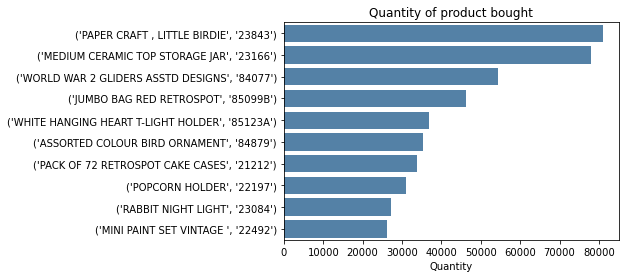

In [76]:
# Plot the Number of times that a product was bought
sns.barplot(x="Quantity", y=totalquantitybyproduct.nlargest(10, columns="Quantity").index, data=totalquantitybyproduct.nlargest(10, columns="Quantity"), color="steelblue")
plt.title("Quantity of product bought")

Text(0.5, 1.0, 'Number of interactions of each product')

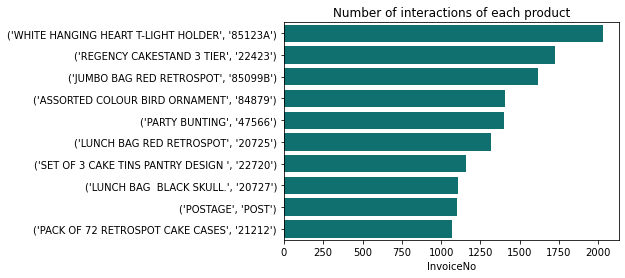

In [77]:
# Plot the Number of interactions of each product
sns.barplot(x="InvoiceNo", y=totalinvoicesbyproduct.nlargest(10, columns="InvoiceNo").index, data=totalinvoicesbyproduct.nlargest(10, columns="InvoiceNo"),color="teal")
plt.title("Number of interactions of each product")

In [78]:
# Initialize the matplotlib figure
#f, ax = plt.subplots(figsize=(12, 8))

# Plot the Number of times that a product was bought
#sns.barplot(x="Quantity", y=totalquantitybyproduct.nlargest(10, columns="Quantity").index, data=totalquantitybyproduct.nlargest(10, columns="Quantity"),
 #           label="Number of times that a product was bought", color="steelblue")

# Plot the Number of interactions of each product
#sns.barplot(x="InvoiceNo", y=totalinvoicesbyproduct.nlargest(10, columns="InvoiceNo").index, data=totalinvoicesbyproduct.nlargest(10, columns="InvoiceNo"),
 #           label="Number of interactions of each product", color="teal")

# Add a legend and informative axis label
#ax.legend(ncol=2, loc="lower right", frameon=True)

In [79]:

retail_nc['Date'] = retail_nc['InvoiceDate'].dt.date
retail_nc['Day'] =retail_nc['InvoiceDate'].dt.day
retail_nc['Month'] = retail_nc['InvoiceDate'].dt.month
retail_nc['Year'] = retail_nc['InvoiceDate'].dt.year
retail_nc['Hour'] = retail_nc['InvoiceDate'].dt.hour
retail_nc['Week'] = retail_nc['InvoiceDate'].dt.week
retail_nc['Minute'] = retail_nc['InvoiceDate'].dt.minute

<ipython-input-79-eac9aa3a2159>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  retail_nc['Date'] = retail_nc['InvoiceDate'].dt.date
<ipython-input-79-eac9aa3a2159>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  retail_nc['Day'] =retail_nc['InvoiceDate'].dt.day
<ipython-input-79-eac9aa3a2159>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org

<ipython-input-82-99213e868e4b>:15: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  sales = retail_nc[retail['Country'] == c]


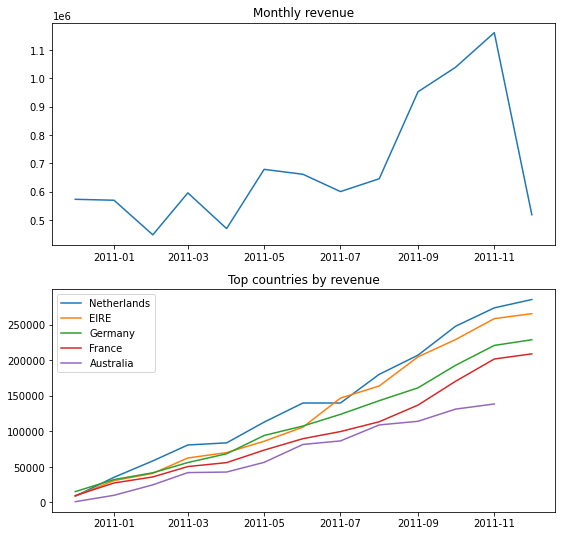

In [82]:
fig, ax = plt.subplots(2,1, figsize=(9, 9))

sales = retail_nc[['Year', 'Month', 'Revenue']].groupby(['Year', 'Month']).sum().reset_index()
sales['Day'] = 1
sales['Date'] = pd.to_datetime(sales[['Year', 'Month', 'Day']])
sales = sales.set_index('Date')
sales = sales.drop(['Year', 'Month', 'Day'], axis=1)

ax[0].plot(sales)
ax[0].set_title('Monthly revenue')        


sales_top = retail_nc[['Revenue', 'Country']].groupby(['Country']).sum().reset_index().sort_values(by='Revenue', ascending=False)['Country'][1:6]
for c in sales_top:
    sales = retail_nc[retail['Country'] == c]
    sales = sales[['Year', 'Month', 'Revenue']].groupby(['Year', 'Month']).sum().reset_index()
    sales['Day'] = 1
    sales['Date'] = pd.to_datetime(sales[['Year', 'Month', 'Day']])
    sales = sales.set_index('Date')
    sales = sales.drop(['Year', 'Month', 'Day'], axis=1)
    ax[1].plot(sales.cumsum(), label=c)    
    ax[1].legend()
    ax[1].set_title('Top countries by revenue')            
    
plt.show()

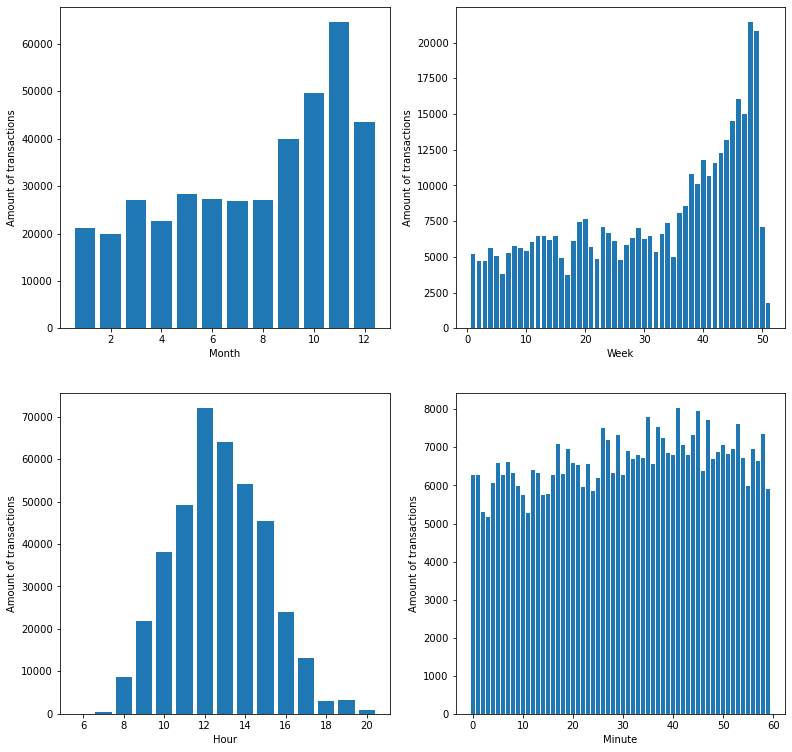

In [83]:
grps = np.array([['Month', 'Week'], ['Hour', 'Minute']])

fig, ax = plt.subplots(grps.shape[0],grps.shape[1], figsize=(13, 13))

for i in range(0, grps.shape[0]):
    for j in range(0, grps.shape[1]):
        grp_data = retail_nc[[grps[i,j], 'InvoiceNo']].groupby([grps[i,j]]).count()
        ax[i,j].bar(x=grp_data.index, height='InvoiceNo', data=grp_data)
        ax[i,j].set_ylabel('Amount of transactions')
        ax[i,j].set_xlabel(grps[i,j])
        
plt.show()

<ipython-input-84-014f69235ef0>:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  grp_data = retail_nc[retail['Country'] == ctry[i,j]]


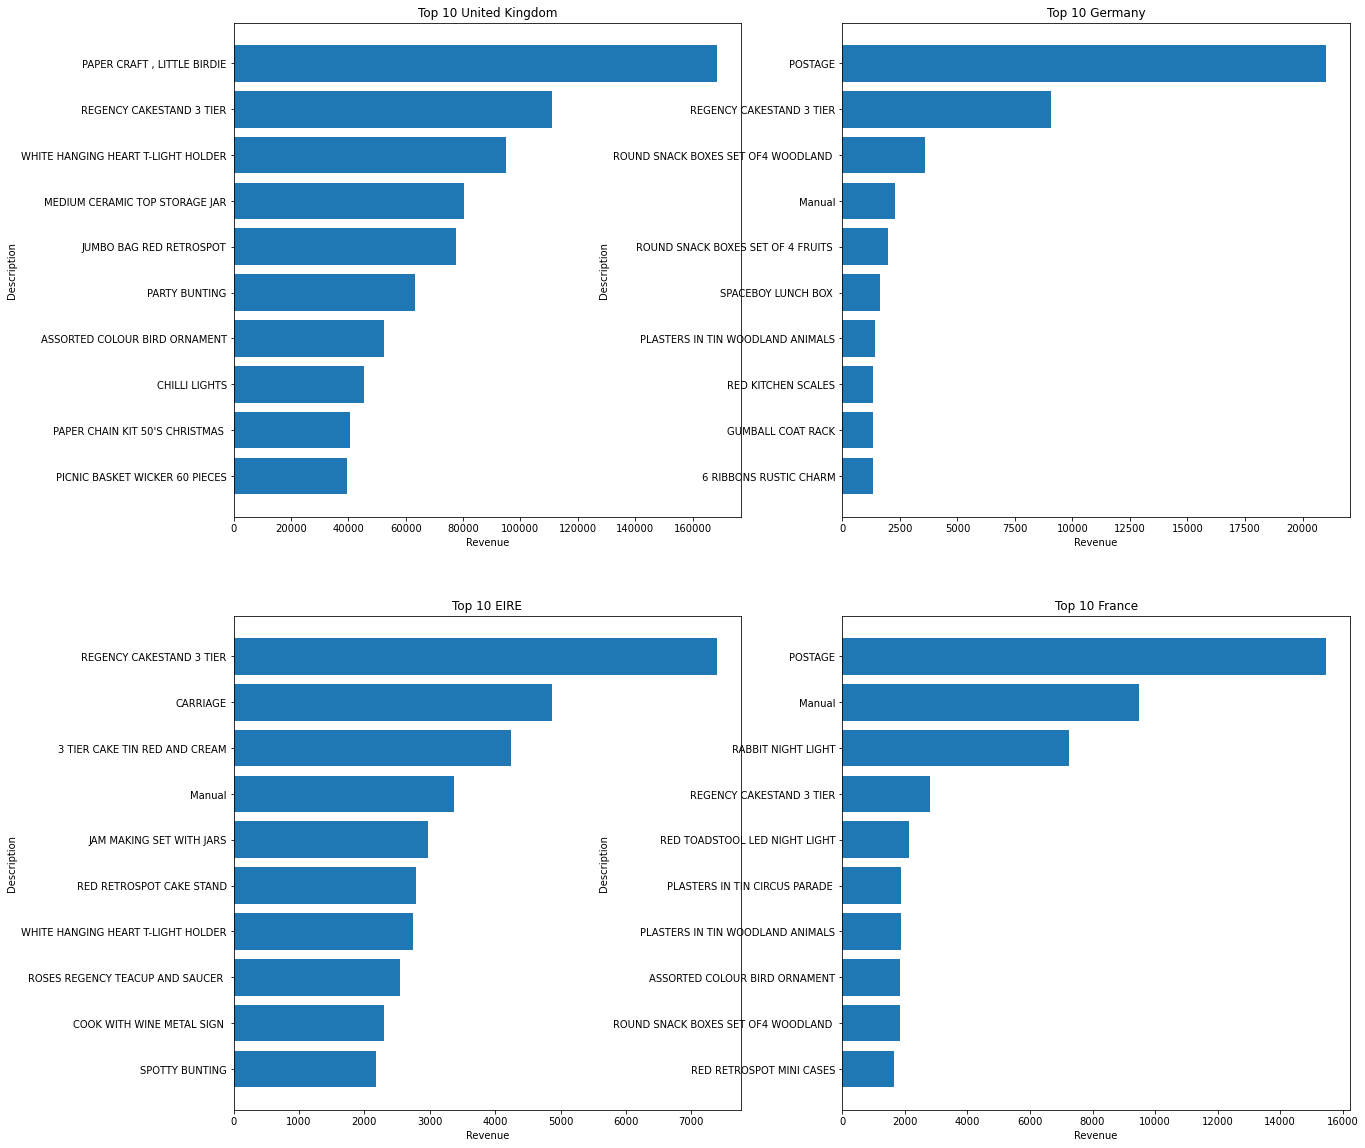

In [84]:
ctry = np.array([['United Kingdom', 'Germany'], ['EIRE', 'France']])
top_n = 10

fig, ax = plt.subplots(grps.shape[0],grps.shape[1], figsize=(20, 20))

for i in range(0, ctry.shape[0]):
    for j in range(0, ctry.shape[1]):
        grp_data = retail_nc[retail['Country'] == ctry[i,j]]
        grp_data = grp_data[['Description', 'Revenue']].groupby(['Description']).sum().sort_values(by='Revenue', ascending=False)        
        grp_data = grp_data[0:top_n]    
        grp_data = grp_data.reset_index()

        ax[i,j].barh(y=grp_data.index, width='Revenue', data=grp_data)
        ax[i,j].invert_yaxis()
        ax[i,j].set_yticks(range(0,top_n))
        ax[i,j].set_yticklabels(grp_data['Description'].tolist())
        ax[i,j].set_ylabel('Description')        
        ax[i,j].set_xlabel('Revenue')                
        ax[i,j].set_title('Top 10 ' + ctry[i,j])        
        
plt.show()


<Figure size 432x288 with 0 Axes>

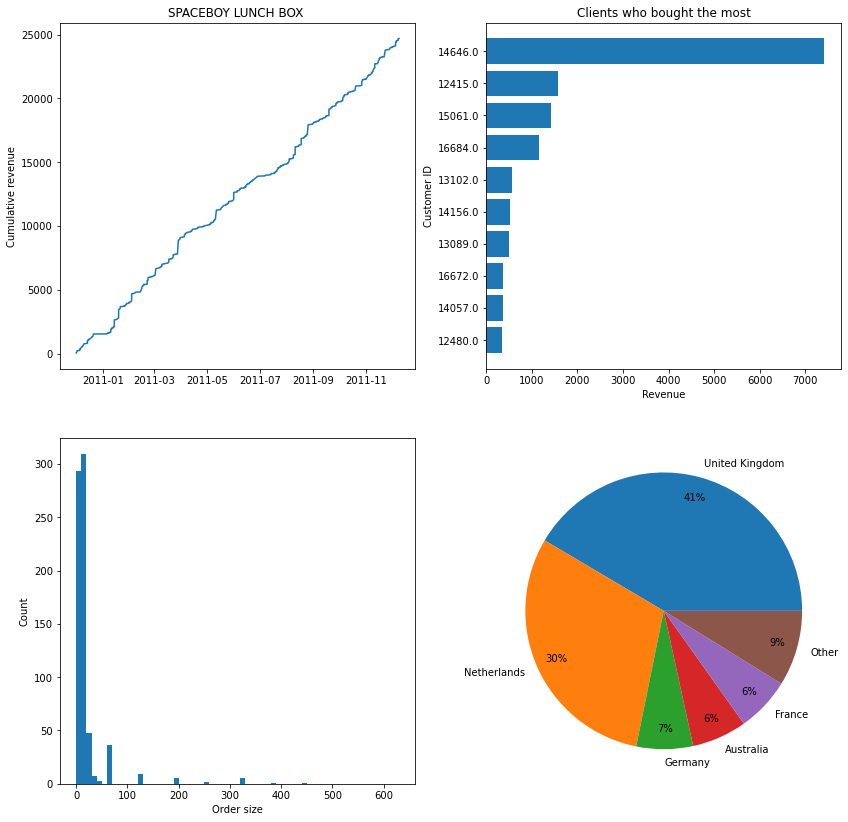

In [85]:
def top_stock(stockcode, top_n):
    """ Plot cumulative sales in pound sterling, 
    clients who bought the most, distribution of order size
    and pie chart with country % of buyers.    
    Parameters:
    stockcode: string with stock id
    top_n: how many bars etc to plot"""

    stock = retail_nc[retail_nc['StockCode'] == stockcode].sort_values(['InvoiceDate'])
    stock['ValueCum'] = stock['Revenue'].cumsum()

    top_buyers = stock[['Revenue', 'CustomerID']].groupby(['CustomerID']).sum().sort_values(by='Revenue', ascending=False).reset_index()
    top_buyers = top_buyers[0:top_n]

    ctry = stock[['Country', 'Revenue']].groupby(['Country']).sum().sort_values(by='Revenue', ascending=False)
    ctry = ((ctry/ctry.sum())*100).round(2)
    ctry = ctry[0:int(top_n/2)]
    ctry = ctry.append(pd.DataFrame(data=[100-ctry.sum()], columns=['Revenue'], index=['Other'] ))

    plt.clf()

    fig, ax = plt.subplots(2,2, figsize=(14, 14))
    
    ax[0,0].plot(stock['InvoiceDate'].dt.date, stock['ValueCum'])
    ax[0,0].set_ylabel('Cumulative revenue')        
    ax[0,0].set_title(stock['Description'].iloc[0]) 
    ax[0,1].invert_yaxis()
    ax[0,1].barh(y=top_buyers.index, width='Revenue', data=top_buyers)
    ax[0,1].set_yticks(range(0,top_n))
    ax[0,1].set_yticklabels(top_buyers['CustomerID'].tolist())
    ax[0,1].set_ylabel('Customer ID')        
    ax[0,1].set_xlabel('Revenue')      
    ax[0,1].set_title("Clients who bought the most")        

    ax[1,0].hist(stock['Quantity'], bins=range(0,stock['Quantity'].max(), top_n) )
    ax[1,0].set_ylabel('Count')        
    ax[1,0].set_xlabel('Order size')     

    ax[1,1].pie(ctry['Revenue'], labels=ctry.index,  autopct='%1.0f%%', pctdistance=0.85)

    plt.show()
    
top_stock(stockcode="22629", top_n = 10) 

### Other info

In [86]:
retail_nc.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 397924 entries, 0 to 541908
Data columns (total 16 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    397924 non-null  object        
 1   StockCode    397924 non-null  object        
 2   Description  397924 non-null  object        
 3   Quantity     397924 non-null  int64         
 4   InvoiceDate  397924 non-null  datetime64[ns]
 5   UnitPrice    397924 non-null  float64       
 6   CustomerID   397924 non-null  object        
 7   Country      397924 non-null  object        
 8   Revenue      397924 non-null  float64       
 9   Date         397924 non-null  object        
 10  Day          397924 non-null  int64         
 11  Month        397924 non-null  int64         
 12  Year         397924 non-null  int64         
 13  Hour         397924 non-null  int64         
 14  Week         397924 non-null  int64         
 15  Minute       397924 non-null  int6

In [87]:
retail_nc.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Revenue,Date,Day,Month,Year,Hour,Week,Minute
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom,15.30,2010-12-01,1,12,2010,8,48,26
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34,2010-12-01,1,12,2010,8,48,26
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom,22.00,2010-12-01,1,12,2010,8,48,26
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34,2010-12-01,1,12,2010,8,48,26
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34,2010-12-01,1,12,2010,8,48,26


In [88]:
retail_nc.describe(include='all').T

,count,unique,top,freq,first,last,mean,std,min,25%,50%,75%,max
InvoiceNo,397924,18536,576339,542,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
StockCode,397924,3665,85123A,2035,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Description,397924,3877,WHITE HANGING HEART T-LIGHT HOLDER,2028,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Quantity,397924,NaN,NaN,NaN,NaT,NaT,13.0218,180.42,1,2,6,12,80995
InvoiceDate,397924,17286,2011-11-14 15:27:00,542,2010-12-01 08:26:00,2011-12-09 12:50:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
UnitPrice,397924,NaN,NaN,NaN,NaT,NaT,3.11617,22.0968,0,1.25,1.95,3.75,8142.75
CustomerID,397924,4339,17841,7847,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Country,397924,37,United Kingdom,354345,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Revenue,397924,NaN,NaN,NaN,NaT,NaT,22.3947,309.056,0,4.68,11.8,19.8,168470
Date,397924,305,2011-11-06,3423,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN


**StockCode** does not totally match with **Description**, as there are less unique stockcodes than unique descriptions of the products.

In [89]:
# How many weeks does the dataset has?
data = pd.DatetimeIndex(retail_nc['InvoiceDate']).normalize().value_counts().sort_index()
diff = (data.index.max() - data.index.min())
print(f"The dataset has {diff.days} days, corresponding to {diff.days//7} weeks.")

The dataset has 373 days, corresponding to 53 weeks.


In [90]:
retail_nc = retail_nc.loc[retail_nc['UnitPrice'] > 0]
retail_nc.describe()

,Quantity,UnitPrice,Revenue,Day,Month,Year,Hour,Week,Minute
count,397884.000000,397884.000000,397884.000000,397884.000000,397884.000000,397884.000000,397884.000000,397884.000000,397884.000000
mean,12.988238,3.116488,22.397000,15.042186,7.612475,2010.934260,12.728202,30.964361,30.407744
std,179.331775,22.097877,309.071041,8.653746,3.416520,0.247828,2.273519,14.755843,17.078307
min,1.000000,0.001000,0.001000,1.000000,1.000000,2010.000000,6.000000,1.000000,0.000000
25%,2.000000,1.250000,4.680000,7.000000,5.000000,2011.000000,11.000000,19.000000,16.000000
50%,6.000000,1.950000,11.800000,15.000000,8.000000,2011.000000,13.000000,34.000000,31.000000
75%,12.000000,3.750000,19.800000,22.000000,11.000000,2011.000000,14.000000,44.000000,45.000000
max,80995.000000,8142.750000,168469.600000,31.000000,12.000000,2011.000000,20.000000,51.000000,59.000000


## COLD START TESTS/EXAMPLES 

In [91]:
#GET ONLY DATA FROM THE LAST MONTH
a=retail_nc.loc[(retail_nc['InvoiceDate'] >= '2011-11-09 00:00')]
a

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Revenue,Date,Day,Month,Year,Hour,Week,Minute
451127,575178,21035,SET/2 RED RETROSPOT TEA TOWELS,100,2011-11-09 08:11:00,2.75,13798,United Kingdom,275.00,2011-11-09,9,11,2011,8,45,11
451128,575178,20685,DOORMAT RED RETROSPOT,10,2011-11-09 08:11:00,7.08,13798,United Kingdom,70.80,2011-11-09,9,11,2011,8,45,11
451129,575179,23110,PARISIENNE KEY CABINET,4,2011-11-09 08:11:00,5.75,14284,United Kingdom,23.00,2011-11-09,9,11,2011,8,45,11
451130,575179,21485,RETROSPOT HEART HOT WATER BOTTLE,3,2011-11-09 08:11:00,4.95,14284,United Kingdom,14.85,2011-11-09,9,11,2011,8,45,11
451131,575179,22558,CLOTHES PEGS RETROSPOT PACK 24,12,2011-11-09 08:11:00,1.65,14284,United Kingdom,19.80,2011-11-09,9,11,2011,8,45,11
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
541904,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,2011-12-09 12:50:00,0.85,12680,France,10.20,2011-12-09,9,12,2011,12,49,50
541905,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,2011-12-09 12:50:00,2.10,12680,France,12.60,2011-12-09,9,12,2011,12,49,50
541906,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,2011-12-09 12:50:00,4.15,12680,France,16.60,2011-12-09,9,12,2011,12,49,50
541907,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,2011-12-09 12:50:00,4.15,12680,France,16.60,2011-12-09,9,12,2011,12,49,50


Text(0.5, 1.0, 'Top 5 most selected products in the last 30 days ')

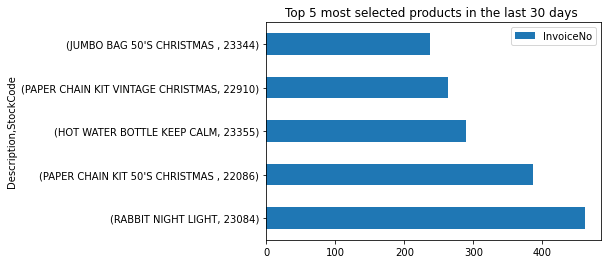

In [92]:
Invoices = pd.DataFrame(a.groupby(["Description",'StockCode']).count()["InvoiceNo"].sort_values(ascending=False))
Invoices.head(5).plot(kind='barh')
plt.title("Top 5 most selected products in the last 30 days ")

Text(0.5, 1.0, 'Top 5 products bought in highest quantities in the last 30 days ')

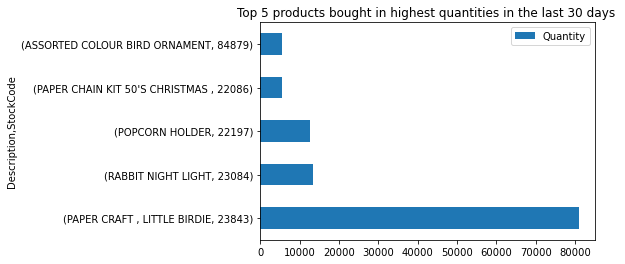

In [93]:
Quantity = pd.DataFrame(a.groupby(["Description",'StockCode']).sum()["Quantity"].sort_values(ascending=False))
Quantity.head(5).plot(kind='barh')
plt.title("Top 5 products bought in highest quantities in the last 30 days ")

Text(0.5, 1.0, 'Top 5 most selected products in the last 30 days - UK')

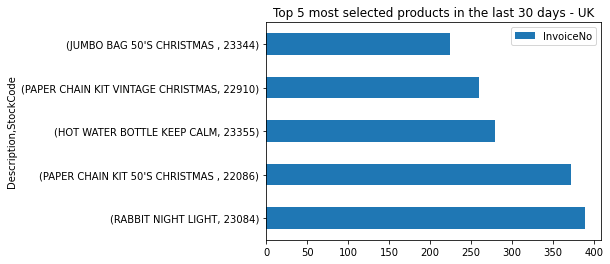

In [94]:
#Focus on the sales in UK
uk=a.loc[(a['Country']== 'United Kingdom')]
#uk

InvoicesUK = pd.DataFrame(uk.groupby(["Description",'StockCode']).count()["InvoiceNo"].sort_values(ascending=False))
InvoicesUK.head(5).plot(kind='barh')
plt.title("Top 5 most selected products in the last 30 days - UK")


Text(0.5, 1.0, 'Top 5 products bought in highest quantities in the last 30 days - UK')

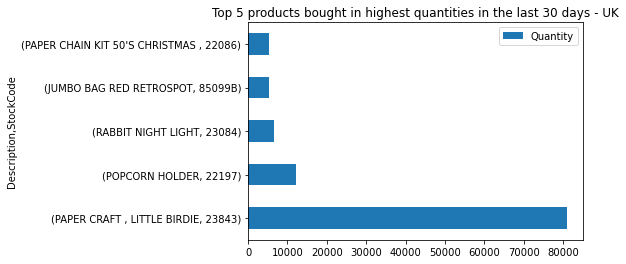

In [95]:
QuantityUK = pd.DataFrame(uk.groupby(["Description",'StockCode']).sum()["Quantity"].sort_values(ascending=False))
QuantityUK.head(5).plot(kind='barh')
plt.title("Top 5 products bought in highest quantities in the last 30 days - UK")

Text(0.5, 1.0, 'Top 5 most selected products in the last 30 days - GR')

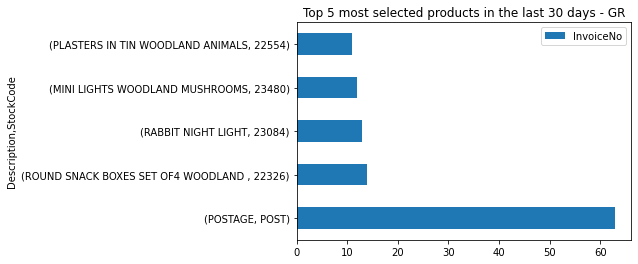

In [96]:
#Focus on the sales in Geramny
g=a.loc[(a['Country']== 'Germany')]
#G

InvoicesG = pd.DataFrame(g.groupby(["Description",'StockCode']).count()["InvoiceNo"].sort_values(ascending=False))
InvoicesG.head(5).plot(kind='barh')
plt.title("Top 5 most selected products in the last 30 days - GR")


Text(0.5, 1.0, 'Top 5 products bought in highest quantities in the last 30 days - GR')

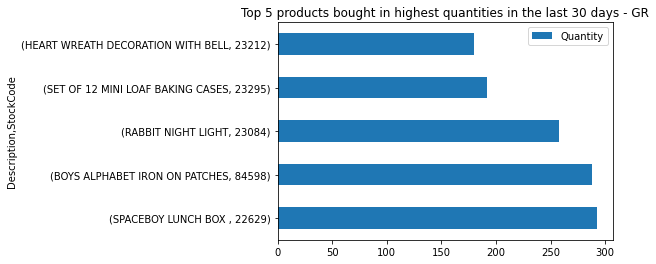

In [97]:
QuantityG = pd.DataFrame(g.groupby(["Description",'StockCode']).sum()["Quantity"].sort_values(ascending=False))
QuantityG.head(5).plot(kind='barh')
plt.title("Top 5 products bought in highest quantities in the last 30 days - GR")

In [98]:
#GET DATA FROM THE LAST WEEK DURING ONLY PEAK HOURS
peak=retail_nc.loc[(retail_nc['InvoiceDate'] >= '2011-12-02 00:00')]
ab=peak.loc[(peak['Hour']>= 12) & (peak['Hour']<= 14)]
ab

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Revenue,Date,Day,Month,Year,Hour,Week,Minute
519861,580188,23331,DECORATIVE WICKER HEART SMALL,10,2011-12-02 12:02:00,0.63,16440,United Kingdom,6.30,2011-12-02,2,12,2011,12,48,2
519862,580188,23329,DECORATIVE WICKER HEART LARGE,9,2011-12-02 12:02:00,1.65,16440,United Kingdom,14.85,2011-12-02,2,12,2011,12,48,2
519863,580188,23330,DECORATIVE WICKER HEART MEDIUM,10,2011-12-02 12:02:00,1.25,16440,United Kingdom,12.50,2011-12-02,2,12,2011,12,48,2
519864,580188,23343,JUMBO BAG VINTAGE CHRISTMAS,4,2011-12-02 12:02:00,2.08,16440,United Kingdom,8.32,2011-12-02,2,12,2011,12,48,2
519865,580188,23344,JUMBO BAG 50'S CHRISTMAS,5,2011-12-02 12:02:00,2.08,16440,United Kingdom,10.40,2011-12-02,2,12,2011,12,48,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
541904,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,2011-12-09 12:50:00,0.85,12680,France,10.20,2011-12-09,9,12,2011,12,49,50
541905,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,2011-12-09 12:50:00,2.10,12680,France,12.60,2011-12-09,9,12,2011,12,49,50
541906,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,2011-12-09 12:50:00,4.15,12680,France,16.60,2011-12-09,9,12,2011,12,49,50
541907,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,2011-12-09 12:50:00,4.15,12680,France,16.60,2011-12-09,9,12,2011,12,49,50


In [99]:
ab['Hour'].value_counts()

12    3253
13    2342
14    2152
Name: Hour, dtype: int64

In [100]:
InvoicesPEAK = pd.DataFrame(ab.groupby(["Description",'StockCode']).count()["InvoiceNo"].sort_values(ascending=False))
InvoicesPEAK.head(3)


,,InvoiceNo
Description,StockCode,
RABBIT NIGHT LIGHT,23084,51
PAPER CHAIN KIT 50'S CHRISTMAS,22086,48
HAND WARMER OWL DESIGN,22865,33


# Reduce Sparsity

> **While implicit recommendations excel where data is sparse, it can often be helpful to make the interactions matrix a little more dense.**

- To reduce sparsity we can exclude users or/and items without significant event history ([cold-start problem](https://en.wikipedia.org/wiki/Cold_start_(recommender_systems)))
- We limited our dataset to users and items with at least 5 event occurrences.

In [77]:
def threshold_ratings(df, uid_min, iid_min, max_iter=None):
    """Removes users and items with less than uid_min and iid_min event occurrences, respectively.
    Credits: https://www.ethanrosenthal.com/2016/10/19/implicit-mf-part-1/
    """
    n_users = df['CustomerID'].nunique()
    n_items = df['StockCode'].nunique()
    sparsity = float(df.shape[0]) / float(n_users * n_items) * 100
    print('Raw dataset info \n-----------------')
    print('Number of users: {}'.format(n_users))
    print('Number of items: {}'.format(n_items))
    print('Sparsity: {:4.3f}%'.format(sparsity))
    
    done, i = False, 0
    while not done:
        # When we exclude users with freq less than uid_min we might end up with new 
        # items with freq less than iid_min, so we will have to alternate back and forth
        starting_shape = df.shape[0]  # number of existing events

        uid_counts = df.groupby('CustomerID').size()  # user id frequencies
        df = df[~df['CustomerID'].isin(uid_counts[uid_counts < uid_min].index.tolist())]  # keep events with users with frequency >= uid_min

        iid_counts = df.groupby('StockCode').size()  # item id frequencies
        df = df[~df['StockCode'].isin(iid_counts[iid_counts < iid_min].index.tolist())]  # keep events with items with frequency >= iid_min

        ending_shape = df.shape[0]  # number of existing events after filters
        i += 1
        if starting_shape == ending_shape or i == max_iter:  # convergence happens
            done = True
    
    if not max_iter:
        assert(df.groupby('CustomerID').size().min() >= uid_min)
        assert(df.groupby('StockCode').size().min() >= iid_min)
    
    n_users = df['CustomerID'].nunique()
    n_items = df['Description'].nunique()
    sparsity = float(df.shape[0]) / float(n_users * n_items) * 100
    print('Limited dataset info \n-----------------')
    print('Number of iterations until convergence: {}'.format(i))
    print('Number of users: {}'.format(n_users))
    print('Number of items: {}'.format(n_items))
    print('Sparsity: {:4.3f}%'.format(sparsity))
    return df

In [78]:
# get limited dataset
df_limited = threshold_ratings(retail_nc, 17, 10)

Raw dataset info 
-----------------
Number of users: 4338
Number of items: 3665
Sparsity: 2.503%
Limited dataset info 
-----------------
Number of iterations until convergence: 3
Number of users: 3271
Number of items: 3081
Sparsity: 3.824%


In [79]:
df_limited.shape

(385425, 9)

In [80]:
retail_nc.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 397884 entries, 0 to 541908
Data columns (total 9 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    397884 non-null  object        
 1   StockCode    397884 non-null  object        
 2   Description  397884 non-null  object        
 3   Quantity     397884 non-null  int64         
 4   InvoiceDate  397884 non-null  datetime64[ns]
 5   UnitPrice    397884 non-null  float64       
 6   CustomerID   397884 non-null  object        
 7   Country      397884 non-null  object        
 8   Revenue      397884 non-null  float64       
dtypes: datetime64[ns](1), float64(2), int64(1), object(5)
memory usage: 30.4+ MB


In [81]:
df_limited.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 385425 entries, 0 to 541908
Data columns (total 9 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    385425 non-null  object        
 1   StockCode    385425 non-null  object        
 2   Description  385425 non-null  object        
 3   Quantity     385425 non-null  int64         
 4   InvoiceDate  385425 non-null  datetime64[ns]
 5   UnitPrice    385425 non-null  float64       
 6   CustomerID   385425 non-null  object        
 7   Country      385425 non-null  object        
 8   Revenue      385425 non-null  float64       
dtypes: datetime64[ns](1), float64(2), int64(1), object(5)
memory usage: 29.4+ MB


## <span style='color:green'> Division into High Season & Low Season datasets </span>

In [82]:
mask = (df_limited['InvoiceDate'] >= '2011-09-01 00:00') 
mask2= (df_limited['InvoiceDate'] < '2011-09-01 00:00') 

In [83]:
HighSeason= df_limited[mask]
LowSeason= df_limited[mask2]

In [84]:
HighSeason

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Revenue
320705,565080,20677,PINK POLKADOT BOWL,8,2011-09-01 08:25:00,1.25,13509,United Kingdom,10.00
320706,565080,22128,PARTY CONES CANDY ASSORTED,24,2011-09-01 08:25:00,1.25,13509,United Kingdom,30.00
320708,565082,22423,REGENCY CAKESTAND 3 TIER,2,2011-09-01 09:15:00,12.75,13305,United Kingdom,25.50
320709,565082,15060B,FAIRY CAKE DESIGN UMBRELLA,8,2011-09-01 09:15:00,3.75,13305,United Kingdom,30.00
320710,565082,23245,SET OF 3 REGENCY CAKE TINS,4,2011-09-01 09:15:00,4.95,13305,United Kingdom,19.80
...,...,...,...,...,...,...,...,...,...
541904,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,2011-12-09 12:50:00,0.85,12680,France,10.20
541905,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,2011-12-09 12:50:00,2.10,12680,France,12.60
541906,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,2011-12-09 12:50:00,4.15,12680,France,16.60
541907,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,2011-12-09 12:50:00,4.15,12680,France,16.60


In [85]:
LowSeason

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Revenue
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34
...,...,...,...,...,...,...,...,...,...
320688,565067,22644,CERAMIC CHERRY CAKE MONEY BANK,2,2011-08-31 17:16:00,1.45,15856,United Kingdom,2.90
320689,565067,22645,CERAMIC HEART FAIRY CAKE MONEY BANK,2,2011-08-31 17:16:00,1.45,15856,United Kingdom,2.90
320690,565067,22637,PIGGY BANK RETROSPOT,2,2011-08-31 17:16:00,2.55,15856,United Kingdom,5.10
320691,565067,22646,CERAMIC STRAWBERRY CAKE MONEY BANK,2,2011-08-31 17:16:00,1.45,15856,United Kingdom,2.90


## <span style='color:green'> OUR SOLUTION - RECOMMENDER SYSTEM </span>
**Source:** https://jessesw.com/Rec-System/

<span style='color:red'> **NOTE:** </span> <br>
As an alert, the recommendations showed in this notebook might not be the same as in the report, because they are not fixed and might change when running the notebook, we are just showing one possible set of recommendations in both deliverables. This could be one of the limitations of our solution, nevertheless, we believe our Recommendation System to be delivering good results not only in terms of performance but also in terms of comprehension as can be seen below and explained in our report.

### <span style='color:teal'> LOW SEASON </span>

In [86]:
cleaned_retail_Low = LowSeason.copy()

In [87]:
cleaned_retail_Low.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 218591 entries, 0 to 320692
Data columns (total 9 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    218591 non-null  object        
 1   StockCode    218591 non-null  object        
 2   Description  218591 non-null  object        
 3   Quantity     218591 non-null  int64         
 4   InvoiceDate  218591 non-null  datetime64[ns]
 5   UnitPrice    218591 non-null  float64       
 6   CustomerID   218591 non-null  object        
 7   Country      218591 non-null  object        
 8   Revenue      218591 non-null  float64       
dtypes: datetime64[ns](1), float64(2), int64(1), object(5)
memory usage: 16.7+ MB


In [88]:
item_lookup_Low = cleaned_retail_Low[['StockCode', 'Description']].drop_duplicates() # Only get unique item/description pairs
item_lookup_Low['StockCode'] = item_lookup_Low.StockCode.astype(str) # Encode as strings for future lookup ease

In [89]:
item_lookup_Low.head()

,StockCode,Description
0,85123A,WHITE HANGING HEART T-LIGHT HOLDER
1,71053,WHITE METAL LANTERN
2,84406B,CREAM CUPID HEARTS COAT HANGER
3,84029G,KNITTED UNION FLAG HOT WATER BOTTLE
4,84029E,RED WOOLLY HOTTIE WHITE HEART.


In [90]:
cleaned_retail_Low['CustomerID'] = cleaned_retail_Low.CustomerID.astype(int) # Convert to int for customer ID
cleaned_retail_Low = cleaned_retail_Low[['StockCode', 'Quantity', 'CustomerID']] # Get rid of unnecessary info
grouped_cleaned_Low = cleaned_retail_Low.groupby(['CustomerID', 'StockCode']).sum().reset_index() # Group together

# Safety measure bellow
grouped_cleaned_Low.Quantity.loc[grouped_cleaned_Low.Quantity == 0] = 1 # Replace a sum of zero purchases with a one to indicate purchased 
grouped_purchased_Low = grouped_cleaned_Low.query('Quantity > 0') # Only get customers where purchase totals were positive

C:\Users\raque\anaconda3\lib\site-packages\pandas\core\indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


In [91]:
grouped_purchased_Low.head()

,CustomerID,StockCode,Quantity
0,12347,16008,24
1,12347,17021,36
2,12347,20665,6
3,12347,20719,20
4,12347,20780,12


In [92]:
customers_Low = list(np.sort(grouped_purchased_Low.CustomerID.unique())) # Get our unique customers
products_Low = list(grouped_purchased_Low.StockCode.unique()) # Get our unique products that were purchased
quantity_Low = list(grouped_purchased_Low.Quantity) # All of our purchases

rows_Low = grouped_purchased_Low.CustomerID.astype('category').cat.codes 
# Get the associated row indices
cols_Low = grouped_purchased_Low.StockCode.astype('category').cat.codes 
# Get the associated column indices
purchases_sparse_Low = sparse.csr_matrix((quantity_Low, (rows_Low, cols_Low)), shape=(len(customers_Low), len(products_Low)))

In [93]:
purchases_sparse_Low

<2602x2671 sparse matrix of type '<class 'numpy.intc'>'
	with 155342 stored elements in Compressed Sparse Row format>

In [94]:
matrix_size_Low = purchases_sparse_Low.shape[0]*purchases_sparse_Low.shape[1] # Number of possible interactions in the matrix
num_purchases_Low = len(purchases_sparse_Low.nonzero()[0]) # Number of items interacted with
sparsity_Low = 100*(1 - (num_purchases_Low/matrix_size_Low))
sparsity_Low

97.76484465625757

**Train Test Split:** Our test set is an exact copy of our original data. The training set, however, will mask a random percentage of user/item interactions and act as if the user never purchased the item (making it a sparse entry with a zero).
<img src="traintestsplit.jpg" alt="MaskTrain" style="width: 400px;"/>

In [95]:
def make_train(ratings, pct_test = 0.2):
    '''
    This function will take in the original user-item matrix and "mask" a percentage of the original ratings where a
    user-item interaction has taken place for use as a test set. The test set will contain all of the original ratings, 
    while the training set replaces the specified percentage of them with a zero in the original ratings matrix. 
    
    parameters: 
    
    ratings - the original ratings matrix from which you want to generate a train/test set. Test is just a complete
    copy of the original set. This is in the form of a sparse csr_matrix. 
    
    pct_test - The percentage of user-item interactions where an interaction took place that you want to mask in the 
    training set for later comparison to the test set, which contains all of the original ratings. 
    
    returns:
    
    training_set - The altered version of the original data with a certain percentage of the user-item pairs 
    that originally had interaction set back to zero.
    
    test_set - A copy of the original ratings matrix, unaltered, so it can be used to see how the rank order 
    compares with the actual interactions.
    
    user_inds - From the randomly selected user-item indices, which user rows were altered in the training data.
    This will be necessary later when evaluating the performance via AUC.
    '''
    test_set = ratings.copy() # Make a copy of the original set to be the test set. 
    test_set[test_set != 0] = 1 # Store the test set as a binary preference matrix
    training_set = ratings.copy() # Make a copy of the original data we can alter as our training set. 
    nonzero_inds = training_set.nonzero() # Find the indices in the ratings data where an interaction exists
    nonzero_pairs = list(zip(nonzero_inds[0], nonzero_inds[1])) # Zip these pairs together of user,item index into list
    random.seed(0) # Set the random seed to zero for reproducibility
    num_samples = int(np.ceil(pct_test*len(nonzero_pairs))) # Round the number of samples needed to the nearest integer
    samples = random.sample(nonzero_pairs, num_samples) # Sample a random number of user-item pairs without replacement
    user_inds = [index[0] for index in samples] # Get the user row indices
    item_inds = [index[1] for index in samples] # Get the item column indices
    training_set[user_inds, item_inds] = 0 # Assign all of the randomly chosen user-item pairs to zero
    training_set.eliminate_zeros() # Get rid of zeros in sparse array storage after update to save space
    return training_set, test_set, list(set(user_inds)) # Output the unique list of user rows that were altered  

In [96]:
product_train_Low, product_test_Low, product_users_altered_Low = make_train(purchases_sparse_Low, pct_test = 0.2)

In [97]:
alpha = 15
user_vecs_Low, item_vecs_Low = implicit.alternating_least_squares((product_train_Low*alpha).astype('double'), 
                                                          factors=20, 
                                                          regularization = 0.1, 
                                                         iterations = 10)

This method is deprecated. Please use the AlternatingLeastSquares class instead


In [98]:
def auc_score(predictions, test):
    '''
    This simple function will output the area under the curve using sklearn's metrics. 
    
    parameters:
    
    - predictions: your prediction output
    
    - test: the actual target result you are comparing to
    
    returns:
    
    - AUC (area under the Receiver Operating Characterisic curve)
    '''
    fpr, tpr, thresholds = metrics.roc_curve(test, predictions)
    return metrics.auc(fpr, tpr)  

In [99]:
def calc_mean_auc(training_set, altered_users, predictions, test_set):
    '''
    This function will calculate the mean AUC by user for any user that had their user-item matrix altered. 
    
    parameters:
    
    training_set - The training set resulting from make_train, where a certain percentage of the original
    user/item interactions are reset to zero to hide them from the model 
    
    predictions - The matrix of your predicted ratings for each user/item pair as output from the implicit MF.
    These should be stored in a list, with user vectors as item zero and item vectors as item one. 
    
    altered_users - The indices of the users where at least one user/item pair was altered from make_train function
    
    test_set - The test set constucted earlier from make_train function
    
    
    
    returns:
    
    The mean AUC (area under the Receiver Operator Characteristic curve) of the test set only on user-item interactions
    there were originally zero to test ranking ability in addition to the most popular items as a benchmark.
    '''
    
    
    store_auc = [] # An empty list to store the AUC for each user that had an item removed from the training set
    popularity_auc = [] # To store popular AUC scores
    pop_items = np.array(test_set.sum(axis = 0)).reshape(-1) # Get sum of item iteractions to find most popular
    item_vecs = predictions[1]
    for user in altered_users: # Iterate through each user that had an item altered
        training_row = training_set[user,:].toarray().reshape(-1) # Get the training set row
        zero_inds = np.where(training_row == 0) # Find where the interaction had not yet occurred
        # Get the predicted values based on our user/item vectors
        user_vec = predictions[0][user,:]
        pred = user_vec.dot(item_vecs).toarray()[0,zero_inds].reshape(-1)
        # Get only the items that were originally zero
        # Select all ratings from the MF prediction for this user that originally had no iteraction
        actual = test_set[user,:].toarray()[0,zero_inds].reshape(-1) 
        # Select the binarized yes/no interaction pairs from the original full data
        # that align with the same pairs in training 
        pop = pop_items[zero_inds] # Get the item popularity for our chosen items
        store_auc.append(auc_score(pred, actual)) # Calculate AUC for the given user and store
        popularity_auc.append(auc_score(pop, actual)) # Calculate AUC using most popular and score
    # End users iteration
    
    return float('%.3f'%np.mean(store_auc)), float('%.3f'%np.mean(popularity_auc))  
   # Return the mean AUC rounded to three decimal places for both test and popularity benchmark

In [100]:
calc_mean_auc(product_train_Low, product_users_altered_Low, 
              [sparse.csr_matrix(user_vecs_Low), sparse.csr_matrix(item_vecs_Low.T)], product_test_Low)
# AUC for our recommender system

(0.839, 0.78)

In [101]:
customers_arr_Low = np.array(customers_Low) # Array of customer IDs from the ratings matrix
products_arr_Low = np.array(products_Low) # Array of product IDs from the ratings matrix

In [102]:
def get_items_purchased(customer_id, mf_train, customers_list, products_list, item_lookup):
    '''
    This just tells me which items have been already purchased by a specific user in the training set. 
    
    parameters: 
    
    customer_id - Input the customer's id number that you want to see prior purchases of at least once
    
    mf_train - The initial ratings training set used (without weights applied)
    
    customers_list - The array of customers used in the ratings matrix
    
    products_list - The array of products used in the ratings matrix
    
    item_lookup - A simple pandas dataframe of the unique product ID/product descriptions available
    
    returns:
    
    A list of item IDs and item descriptions for a particular customer that were already purchased in the training set
    '''
    cust_ind = np.where(customers_list == customer_id)[0][0] # Returns the index row of our customer id
    purchased_ind = mf_train[cust_ind,:].nonzero()[1] # Get column indices of purchased items
    prod_codes = products_list[purchased_ind] # Get the stock codes for our purchased items
    return item_lookup.loc[item_lookup.StockCode.isin(prod_codes)]

In [103]:
lowcust = pd.DataFrame(LowSeason['CustomerID'].value_counts())
lowcust.loc[(lowcust['CustomerID'] > 50) & (lowcust['CustomerID'] < 100)]

,CustomerID
17213.0,99
14584.0,99
15862.0,99
12383.0,99
15827.0,99
...,...
17293.0,51
16092.0,51
17669.0,51
13186.0,51


In [104]:
lowcust

,CustomerID
17841.0,4186
14911.0,2716
12748.0,1930
14606.0,1912
15311.0,1688
...,...
13211.0,2
14285.0,1
17190.0,1
15885.0,1


In [105]:
get_items_purchased(17841, product_train_Low, customers_arr_Low, products_arr_Low, item_lookup_Low)

,StockCode,Description
2,84406B,CREAM CUPID HEARTS COAT HANGER
7,22633,HAND WARMER UNION JACK
16,22622,BOX OF VINTAGE ALPHABET BLOCKS
17,21754,HOME BUILDING BLOCK WORD
18,21755,LOVE BUILDING BLOCK WORD
...,...,...
311445,23445,ICE CREAM BUBBLES
314936,23348,CHILDRENS TOY COOKING UTENSIL SET
315165,82486,3 DRAWER ANTIQUE WHITE WOOD CABINET
319310,23433,HANGING QUILTED PATCHWORK APPLES


In [106]:
get_items_purchased(13892, product_train_Low, customers_arr_Low, products_arr_Low, item_lookup_Low)

,StockCode,Description
192,22969,HOMEMADE JAM SCENTED CANDLES
244,21891,TRADITIONAL WOODEN SKIPPING ROPE


In [107]:
get_items_purchased(15862, product_train_Low, customers_arr_Low, products_arr_Low, item_lookup_Low)

,StockCode,Description
17,21754,HOME BUILDING BLOCK WORD
112,22771,CLEAR DRAWER KNOB ACRYLIC EDWARDIAN
117,21169,YOU'RE CONFUSING ME METAL SIGN
140,21523,DOORMAT FANCY FONT HOME SWEET HOME
248,22128,PARTY CONES CANDY ASSORTED
...,...,...
211438,23309,SET OF 60 I LOVE LONDON CAKE CASES
222973,23264,SET OF 3 WOODEN SLEIGH DECORATIONS
226399,23013,GLASS APOTHECARY BOTTLE TONIC
234346,23023,RIDGED BONNE JAM JAR T-LIGHT HOLDER


In [108]:
def rec_items(customer_id, mf_train, user_vecs, item_vecs, customer_list, item_list, item_lookup, num_items = 10):
    '''
    This function will return the top recommended items to our users 
    
    parameters:
    
    customer_id - Input the customer's id number that you want to get recommendations for
    
    mf_train - The training matrix you used for matrix factorization fitting
    
    user_vecs - the user vectors from your fitted matrix factorization
    
    item_vecs - the item vectors from your fitted matrix factorization
    
    customer_list - an array of the customer's ID numbers that make up the rows of your ratings matrix 
                    (in order of matrix)
    
    item_list - an array of the products that make up the columns of your ratings matrix
                    (in order of matrix)
    
    item_lookup - A simple pandas dataframe of the unique product ID/product descriptions available
    
    num_items - The number of items you want to recommend in order of best recommendations. Default is 10. 
    
    returns:
    
    - The top n recommendations chosen based on the user/item vectors for items never interacted with/purchased
    '''
    
    cust_ind = np.where(customer_list == customer_id)[0][0] # Returns the index row of our customer id
    pref_vec = mf_train[cust_ind,:].toarray() # Get the ratings from the training set ratings matrix
    pref_vec = pref_vec.reshape(-1) + 1 # Add 1 to everything, so that items not purchased yet become equal to 1
    pref_vec[pref_vec > 1] = 0 # Make everything already purchased zero
    rec_vector = user_vecs[cust_ind,:].dot(item_vecs.T) # Get dot product of user vector and all item vectors
    # Scale this recommendation vector between 0 and 1
    min_max = MinMaxScaler()
    rec_vector_scaled = min_max.fit_transform(rec_vector.reshape(-1,1))[:,0] 
    recommend_vector = pref_vec*rec_vector_scaled 
    # Items already purchased have their recommendation multiplied by zero
    product_idx = np.argsort(recommend_vector)[::-1][:num_items] # Sort the indices of the items into order 
    # of best recommendations
    rec_list = [] # start empty list to store items
    for index in product_idx:
        code = item_list[index]
        rec_list.append([code, item_lookup.Description.loc[item_lookup.StockCode == code].iloc[0]]) 
        # Append our descriptions to the list
    codes = [item[0] for item in rec_list]
    descriptions = [item[1] for item in rec_list]
    final_frame = pd.DataFrame({'StockCode': codes, 'Description': descriptions}) # Create a dataframe 
    return final_frame[['StockCode', 'Description']] # Switch order of columns around

In [109]:
rec_items(17841, product_train_Low, user_vecs_Low, item_vecs_Low, customers_arr_Low, products_arr_Low, item_lookup_Low,
                       num_items = 10)

,StockCode,Description
0,22734,SET OF 6 RIBBONS VINTAGE CHRISTMAS
1,22827,RUSTIC SEVENTEEN DRAWER SIDEBOARD
2,72780,BLACK SILOUETTE CANDLE PLATE
3,79063D,"RETRO PILL BOX , REVOLUTIONARY"
4,21890,S/6 WOODEN SKITTLES IN COTTON BAG
5,84673A,PINK FLY SWAT
6,23060,HEART BEADED TRELLIS DECORATION
7,84796B,BLUE SAVANNAH PICNIC HAMPER FOR 2
8,35914,PINK CHICK EGG WARMER + EGG CUP
9,22799,SWEETHEART WIRE FRUIT BOWL


In [110]:
rec_items(13892, product_train_Low, user_vecs_Low, item_vecs_Low, customers_arr_Low, products_arr_Low, item_lookup_Low,
                       num_items = 10)

,StockCode,Description
0,21843,RED RETROSPOT CAKE STAND
1,22666,RECIPE BOX PANTRY YELLOW DESIGN
2,22332,SKULLS PARTY BAG + STICKER SET
3,16225,RATTLE SNAKE EGGS
4,22933,BAKING MOULD EASTER EGG MILK CHOC
5,22075,6 RIBBONS ELEGANT CHRISTMAS
6,21473,SWEETHEART CREAM STEEL TABLE RECT
7,84707B,PINK JEWELLED MIRROR TRINKET TRAY
8,20845,ZINC HEART LATTICE 2 WALL PLANTER
9,21172,PARTY METAL SIGN


In [111]:
rec_items(15862, product_train_Low, user_vecs_Low, item_vecs_Low, customers_arr_Low, products_arr_Low, item_lookup_Low,
                       num_items = 10)

,StockCode,Description
0,22860,EASTER TIN CHICKS PINK DAISY
1,84789,ENCHANTED BIRD PLANT CAGE
2,72586,SET OF 6 HALLOWEEN GHOST T-LIGHTS
3,82613A,"METAL SIGN,CUPCAKE SINGLE HOOK"
4,21556,CERAMIC STRAWBERRY MONEY BOX
5,23084,RABBIT NIGHT LIGHT
6,84461,12 PINK HEN+CHICKS IN BASKET
7,22548,HEADS AND TAILS SPORTING FUN
8,22204,MILK PAN BLUE POLKADOT
9,22894,TABLECLOTH RED APPLES DESIGN


In [112]:
get_items_purchased(17190, product_train_Low, customers_arr_Low, products_arr_Low, item_lookup_Low)

,StockCode,Description
1209,21658,GLASS BEURRE DISH


In [113]:
LowSeason.loc[LowSeason['CustomerID'] == 17190][['Description', 'StockCode']]

,Description,StockCode
191600,LOVE SEAT ANTIQUE WHITE METAL,22826


In [114]:
rec_items(17190, product_train_Low, user_vecs_Low, item_vecs_Low, customers_arr_Low, products_arr_Low, item_lookup_Low,
                       num_items = 10)

,StockCode,Description
0,22452,MEASURING TAPE BABUSHKA PINK
1,22303,COFFEE MUG APPLES DESIGN
2,22032,BOTANICAL LILY GREETING CARD
3,21263,GREEN GOOSE FEATHER TREE 60CM
4,21675,BUTTERFLIES STICKERS
5,21749,LARGE RED RETROSPOT WINDMILL
6,85160B,BLACK BIRD GARDEN DESIGN MUG
7,20766,GARDEN PATH SKETCHBOOK
8,21711,FOLDING UMBRELLA WHITE/RED POLKADOT
9,23286,BLUE VINTAGE SPOT BEAKER


### <span style='color:teal'> HIGH SEASON </span>

In [115]:
cleaned_retail_High = HighSeason.copy()

In [116]:
cleaned_retail_High.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 166834 entries, 320705 to 541908
Data columns (total 9 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    166834 non-null  object        
 1   StockCode    166834 non-null  object        
 2   Description  166834 non-null  object        
 3   Quantity     166834 non-null  int64         
 4   InvoiceDate  166834 non-null  datetime64[ns]
 5   UnitPrice    166834 non-null  float64       
 6   CustomerID   166834 non-null  object        
 7   Country      166834 non-null  object        
 8   Revenue      166834 non-null  float64       
dtypes: datetime64[ns](1), float64(2), int64(1), object(5)
memory usage: 12.7+ MB


In [117]:
item_lookup_High = cleaned_retail_High[['StockCode', 'Description']].drop_duplicates() # Only get unique item/description pairs
item_lookup_High['StockCode'] = item_lookup_High.StockCode.astype(str) # Encode as strings for future lookup ease

In [118]:
item_lookup_High.head()

,StockCode,Description
320705,20677,PINK POLKADOT BOWL
320706,22128,PARTY CONES CANDY ASSORTED
320708,22423,REGENCY CAKESTAND 3 TIER
320709,15060B,FAIRY CAKE DESIGN UMBRELLA
320710,23245,SET OF 3 REGENCY CAKE TINS


In [119]:
cleaned_retail_High['CustomerID'] = cleaned_retail_High.CustomerID.astype(int) # Convert to int for customer ID
cleaned_retail_High = cleaned_retail_High[['StockCode', 'Quantity', 'CustomerID']] # Get rid of unnecessary info
grouped_cleaned_High = cleaned_retail_High.groupby(['CustomerID', 'StockCode']).sum().reset_index() # Group together

# Safety measure bellow
grouped_cleaned_High.Quantity.loc[grouped_cleaned_High.Quantity == 0] = 1 # Replace a sum of zero purchases with a one to indicate purchased 
grouped_purchased_High = grouped_cleaned_High.query('Quantity > 0') # Only get customers where purchase totals were positive

C:\Users\raque\anaconda3\lib\site-packages\pandas\core\indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


In [120]:
grouped_purchased_High.head()

,CustomerID,StockCode,Quantity
0,12347,20719,20
1,12347,21064,24
2,12347,21265,24
3,12347,21636,12
4,12347,21731,36


In [121]:
customers_High = list(np.sort(grouped_purchased_High.CustomerID.unique())) # Get our unique customers
products_High = list(grouped_purchased_High.StockCode.unique()) # Get our unique products that were purchased
quantity_High = list(grouped_purchased_High.Quantity) # All of our purchases

rows_High = grouped_purchased_High.CustomerID.astype('category').cat.codes 
# Get the associated row indices
cols_High = grouped_purchased_High.StockCode.astype('category').cat.codes 
# Get the associated column indices
purchases_sparse_High = sparse.csr_matrix((quantity_High, (rows_High, cols_High)), shape=(len(customers_High), len(products_High)))

In [122]:
purchases_sparse_High

<2495x2651 sparse matrix of type '<class 'numpy.intc'>'
	with 127481 stored elements in Compressed Sparse Row format>

In [123]:
matrix_size_High = purchases_sparse_High.shape[0]*purchases_sparse_High.shape[1] # Number of possible interactions in the matrix
num_purchases_High = len(purchases_sparse_High.nonzero()[0]) # Number of items interacted with
sparsity_High = 100*(1 - (num_purchases_High/matrix_size_High))
sparsity_High

98.07262960473948

In [124]:
product_train_High, product_test_High, product_users_altered_High = make_train(purchases_sparse_High, pct_test = 0.2)

In [125]:
alpha = 15
user_vecs_High, item_vecs_High = implicit.alternating_least_squares((product_train_High*alpha).astype('double'), 
                                                          factors=20, 
                                                          regularization = 0.1, 
                                                         iterations = 10)

In [126]:
calc_mean_auc(product_train_High, product_users_altered_High, 
              [sparse.csr_matrix(user_vecs_High), sparse.csr_matrix(item_vecs_High.T)], product_test_High)
# AUC for our recommender system

(0.841, 0.798)

In [127]:
customers_arr_High = np.array(customers_High) # Array of customer IDs from the ratings matrix
products_arr_High = np.array(products_High) # Array of product IDs from the ratings matrix

In [128]:
highcust = pd.DataFrame(HighSeason['CustomerID'].value_counts())
highcust.loc[(highcust['CustomerID'] > 100) & (highcust['CustomerID'] < 300)]

,CustomerID
14796.0,299
16931.0,297
12921.0,296
14071.0,293
14088.0,292
...,...
12607.0,101
15786.0,101
16395.0,101
12583.0,101


In [129]:
highcust.loc[(highcust['CustomerID'] == 2)]

,CustomerID
13405.0,2
15764.0,2
16122.0,2
18093.0,2
17736.0,2
12356.0,2
13311.0,2
14737.0,2
14448.0,2
17892.0,2


In [130]:
highcust

,CustomerID
14096.0,5059
17841.0,3615
14911.0,2871
12748.0,2587
16549.0,838
...,...
13122.0,1
12461.0,1
12843.0,1
15810.0,1


In [131]:
get_items_purchased(14096, product_train_High, customers_arr_High, products_arr_High, item_lookup_High)

,StockCode,Description
320706,22128,PARTY CONES CANDY ASSORTED
320712,22741,FUNKY DIVA PEN
320717,22489,PACK OF 12 TRADITIONAL CRAYONS
320721,22212,FOUR HOOK WHITE LOVEBIRDS
320722,23309,SET OF 60 I LOVE LONDON CAKE CASES
...,...,...
502971,23578,SNACK TRAY RED GINGHAM
503150,23580,SNACK TRAY HAPPY FOREST
503268,22516,CHILDS GARDEN RAKE BLUE
503602,23562,SET OF 6 RIBBONS PERFECTLY PRETTY


In [132]:
rec_items(14096, product_train_High, user_vecs_High, item_vecs_High, customers_arr_High, products_arr_High, item_lookup_High,
                       num_items = 10)

,StockCode,Description
0,22773,GREEN DRAWER KNOB ACRYLIC EDWARDIAN
1,22984,CARD GINGHAM ROSE
2,48194,DOORMAT HEARTS
3,46000M,POLYESTER FILLER PAD 45x45cm
4,23550,WRAP ALPHABET POSTER
5,21695,SMALL SILVER FLOWER CANDLE POT
6,22105,MIRROR MOSAIC GOBLET CANDLE HOLDER
7,84030E,ENGLISH ROSE HOT WATER BOTTLE
8,21725,SWEETIES STICKERS
9,84880,WHITE WIRE EGG HOLDER


In [133]:
get_items_purchased(16103, product_train_High, customers_arr_High, products_arr_High, item_lookup_High)

,StockCode,Description
321359,17003,BROCADE RING PURSE
321790,22185,SLATE TILE NATURAL HANGING
323302,22378,WALL TIDY RETROSPOT
323989,22354,RETROSPOT PADDED SEAT CUSHION
325977,22971,QUEENS GUARD COFFEE MUG
328242,22227,HANGING HEART MIRROR DECORATION
330152,23409,PHOTO FRAME LINEN AND LACE LARGE


In [134]:
rec_items(16103, product_train_High, user_vecs_High, item_vecs_High, customers_arr_High, products_arr_High, item_lookup_High,
                       num_items = 10)

,StockCode,Description
0,20759,CHRYSANTHEMUM POCKET BOOK
1,21485,RETROSPOT HEART HOT WATER BOTTLE
2,22231,JIGSAW TREE WITH BIRDHOUSE
3,22541,MINI JIGSAW LEAP FROG
4,21640,ASSORTED TUTTI FRUTTI FOB NOTEBOOK
5,23323,WHITE WICKER STAR
6,81952V,ROUND PURPLE CLOCK WITH SUCKER
7,20985,HEART CALCULATOR
8,22810,SET OF 6 T-LIGHTS SNOWMEN
9,22260,FELT EGG COSY BLUE RABBIT


In [135]:
get_items_purchased(12921, product_train_High, customers_arr_High, products_arr_High, item_lookup_High)

,StockCode,Description
320735,37449,CERAMIC CAKE STAND + HANGING CAKES
320752,23275,SET OF 3 HANGING OWLS OLLIE BEAK
320810,22546,MINI JIGSAW PURDEY
320883,82600,NO SINGING METAL SIGN
320910,22360,GLASS JAR ENGLISH CONFECTIONERY
...,...,...
443314,23143,ZINC WIRE KITCHEN ORGANISER
493113,21366,MIRRORED WALL ART PHOTO FRAMES
495384,85163B,BLACK BAROQUE WALL CLOCK
499914,23498,CLASSIC BICYCLE CLIPS


In [136]:
rec_items(12921, product_train_High, user_vecs_High, item_vecs_High, customers_arr_High, products_arr_High, item_lookup_High,
                       num_items = 10)

,StockCode,Description
0,35967,FOLK ART METAL STAR T-LIGHT HOLDER
1,21640,ASSORTED TUTTI FRUTTI FOB NOTEBOOK
2,23695,DOILY THANK YOU CARD
3,85227,SET OF 6 3D KIT CARDS FOR KIDS
4,22229,BUNNY WOODEN PAINTED WITH FLOWER
5,21902,"KEY FOB , FRONT DOOR"
6,84707B,PINK JEWELLED MIRROR TRINKET TRAY
7,22341,LOVE GARLAND PAINTED ZINC
8,23145,ZINC T-LIGHT HOLDER STAR LARGE
9,21867,PINK UNION JACK LUGGAGE TAG


In [137]:
get_items_purchased(14448, product_train_High, customers_arr_High, products_arr_High, item_lookup_High)

,StockCode,Description
358948,20658,RED RETROSPOT LUGGAGE TAG
410358,90160C,TURQ+RED BOUDICCA LARGE BRACELET


In [138]:
HighSeason.loc[HighSeason['CustomerID'] == 14448][['StockCode', 'Description']]

,StockCode,Description
514203,85123A,WHITE HANGING HEART T-LIGHT HOLDER
514204,85014A,BLACK/BLUE POLKADOT UMBRELLA


In [139]:
rec_items(14448, product_train_High, user_vecs_High, item_vecs_High, customers_arr_High, products_arr_High, item_lookup_High,
                       num_items = 10)

,StockCode,Description
0,21420,OYSTER TRINKET BOX
1,23015,CORDIAL GLASS JUG
2,20727,LUNCH BAG BLACK SKULL.
3,22611,VINTAGE UNION JACK SHOPPING BAG
4,23524,HORSE & PONY WALL ART
5,21579,LOLITA DESIGN COTTON TOTE BAG
6,22339,CHRISTMAS TREE PAINTED ZINC
7,20963,APPLE BATH SPONGE
8,21467,CHERRY CROCHET FOOD COVER
9,21224,SET/4 SKULL BADGES


In [140]:
get_items_purchased(16122, product_train_High, customers_arr_High, products_arr_High, item_lookup_High)

,StockCode,Description
328868,22759,SET OF 3 NOTEBOOKS IN PARCEL
333775,22703,PINK CAT BOWL


In [141]:
rec_items(16122, product_train_High, user_vecs_High, item_vecs_High, customers_arr_High, products_arr_High, item_lookup_High,
                       num_items = 10)

,StockCode,Description
0,21967,PACK OF 12 SKULL TISSUES
1,22425,ENAMEL COLANDER CREAM
2,22348,TEA BAG PLATE RED RETROSPOT
3,20755,BLUE PAISLEY POCKET BOOK
4,21371,MIRRORED WALL ART POPPIES
5,84754,S/15 SILVER GLASS BAUBLES IN BAG
6,16011,ANIMAL STICKERS
7,23191,BUNDLE OF 3 RETRO NOTE BOOKS
8,21695,SMALL SILVER FLOWER CANDLE POT
9,21452,TOADSTOOL MONEY BOX


### --------------------------------------------------------------------------------------------------------------------------------------------------------------

### <span style='color:gray'> NOTE: </span> 
Other two models were performed, but not used as our final solution, that is why they were not mention in our report. In this way, our report only mentions what has been done until this point of the notebook.

## <span style='color:green'> SIMPLER RECOMMENDER </span>
**Source:** https://www.kaggle.com/sebjwallace/ecommerce-product-recommendation-eda

### <span style='color:teal'> LOW SEASON </span>

In [142]:
customerProductMatrix = LowSeason.pivot_table(index='CustomerID', columns='StockCode', values='Quantity', fill_value=0, aggfunc='sum')
customerProductMatrix

StockCode,10002,10080,10120,10125,10133,10135,11001,15030,15034,15036,...,90201C,90209B,90209C,90214A,90214K,BANK CHARGES,C2,DOT,M,POST
CustomerID,,,,,,,,,,,,,,,,,,,,,
12347.0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
12348.0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,8
12350.0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
12352.0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,3,2
12354.0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18263.0,0,0,0,0,20,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
18265.0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
18272.0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [143]:
numberOfCustomerProductRelations = customerProductMatrix.size
numberOfCustomerProductRelationsFillfilled = np.count_nonzero(customerProductMatrix)
sparsity = 1 - (numberOfCustomerProductRelationsFillfilled / numberOfCustomerProductRelations)
density = 1 - sparsity
pd.DataFrame([{
    '#CustomerProductRelations': numberOfCustomerProductRelations,
    '#CustomerProductRelationsFullfilled': numberOfCustomerProductRelationsFillfilled,
    'Sparsity': sparsity,
    'Density': density
}], index=['quantity'])

,#CustomerProductRelations,#CustomerProductRelationsFullfilled,Sparsity,Density
quantity,6949942,155342,0.977648,0.022352


"*The table is highly sparse. To give an idea we've rendered an image of the table below (each pixel is a cell in the table/matrix) to easier see the density. Given the rows are customers and the columns are products - we can immediately see the highly active buyers and highly sold products.*"

In [144]:
def showVector(vector):
    plt.figure(figsize = (100,100))
    plt.imshow(vector, aspect = 100)

def sigmoid(x):
  return 1 / (1 + math.exp(-x))
sigmoid = np.vectorize(sigmoid)

"*Using the sample customer vector we can compare it to all the other customer vectors in the matrix and calculate the euclidean distance. The vector above displays the distances across the customer axis of the matrix (a vector of all customers and how similar they are to the sample customer). It shows small variance which tells us that this customer is somewhat similar to most other customers (thus small distance values). We've plotted the vector below to better display the distance values.*"

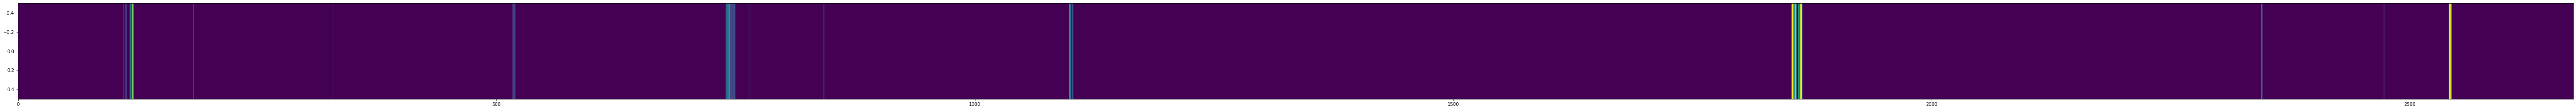

In [145]:
sampleCustomerID = 18177
sampleCustomer = np.asarray(customerProductMatrix.loc[sampleCustomerID])
sampleCustomer = np.reshape(sampleCustomer, [1, sampleCustomer.shape[0]])
showVector(sampleCustomer)

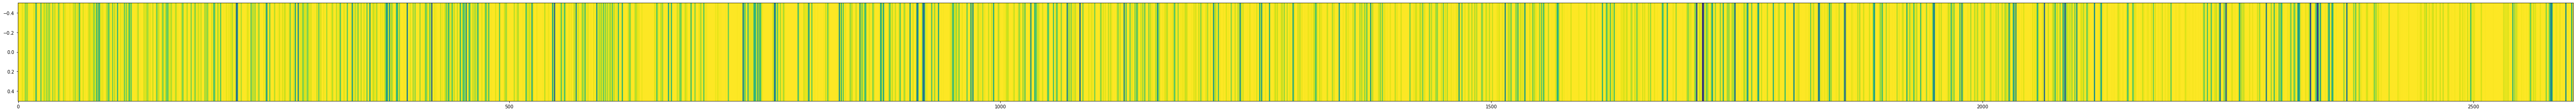

In [146]:
sampleCustomerIndex = customerProductMatrix.index.get_loc(sampleCustomerID)
distances = scipy.spatial.distance.cdist(customerProductMatrix, sampleCustomer, metric='cosine')
distances[sampleCustomerIndex][0] = distances.mean()
bestMatchingCustomer = customerProductMatrix[distances == distances.min()]
bestMatchIndex = distances.argmin()

showVector(np.reshape(distances, [1, distances.shape[0]]))

"*We'll pick an arbitrary customer and render their 'customer vector', which is simply a row in the matrix above. We've vertically streched the image of the 1d vector so that it's more visible. The cooler colours are lower numbers/quantities and hotter colors higher numbers/quantities.*"

In [147]:
customerProductMatrix['Distances'] = distances
customerProductMatrix = customerProductMatrix.sort_values('Distances')
customerProductMatrix.head()

StockCode,10002,10080,10120,10125,10133,10135,11001,15030,15034,15036,...,90209B,90209C,90214A,90214K,BANK CHARGES,C2,DOT,M,POST,Distances
CustomerID,,,,,,,,,,,,,,,,,,,,,
16180.0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.252177
16161.0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.296417
17669.0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.299830
17677.0,24,0,0,0,0,0,0,0,0,12,...,0,0,0,0,0,0,0,0,0,0.300208
17469.0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.325215


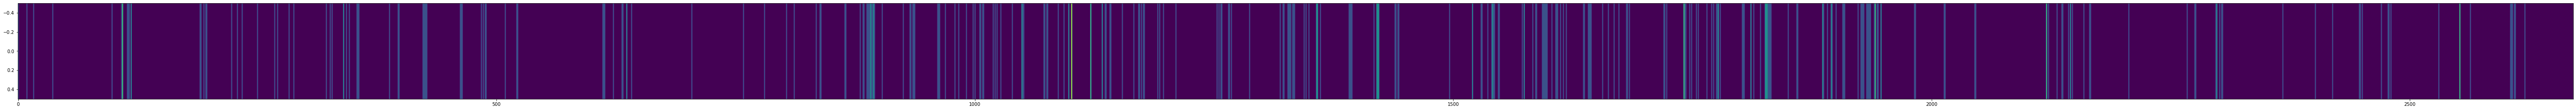

In [148]:
del customerProductMatrix['Distances']
bestMatchingCustomers = customerProductMatrix.head()
bestMatchingCustomerBinaries = np.where(bestMatchingCustomers > 0, 1, 0)
consensus = np.expand_dims(np.sum(bestMatchingCustomerBinaries, axis=0), 0)
consensus[sampleCustomer > 0] = 0
showVector(consensus)

In [149]:
customerProductMatrix.loc['Rank'] = np.squeeze(consensus, 0)
customerProductMatrix = customerProductMatrix.T.sort_values('Rank', ascending=False)
recommendedProducts = customerProductMatrix[customerProductMatrix['Rank'] > 0]
recommendedProducts

CustomerID,16180.0,16161.0,17669.0,17677.0,17469.0,14709.0,16523.0,13238.0,17068.0,13534.0,...,15090.0,15081.0,15073.0,15071.0,15068.0,15067.0,15061.0,15095.0,18287.0,Rank
StockCode,,,,,,,,,,,,,,,,,,,,,
22385,100,3,50,0,10,30,20,0,0,20,...,0,0,0,0,0,0,0,0,0,4
85123A,0,1,6,0,6,0,0,0,0,0,...,0,12,0,0,0,0,0,0,0,3
23298,0,0,12,50,3,0,0,0,27,3,...,0,0,0,0,0,0,0,0,0,3
22411,200,30,0,0,10,60,140,10,10,60,...,10,0,0,0,0,0,0,0,0,3
23076,96,0,24,24,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,24,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20974,24,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
84945,0,0,0,0,12,0,36,0,0,0,...,0,0,0,0,0,0,0,0,0,1
85186C,0,2,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [150]:
recommendedProducts = [recommendedProducts['Rank']]
recommendedProducts = pd.DataFrame(recommendedProducts).T
recommendedProductsTop = recommendedProducts.head(10)
recommendedProductsTop

,Rank
StockCode,
22385,4
85123A,3
23298,3
22411,3
23076,3
47566,3
20712,3
21754,2
23172,2


In [151]:
LowSeason.loc[LowSeason['StockCode'].isin(recommendedProductsTop.index.tolist())]['Description'].unique()

array(['WHITE HANGING HEART T-LIGHT HOLDER', 'HOME BUILDING BLOCK WORD',
       'JUMBO SHOPPER VINTAGE RED PAISLEY', 'HOT WATER BOTTLE BABUSHKA ',
       'JUMBO BAG WOODLAND ANIMALS', 'JUMBO BAG SPACEBOY DESIGN',
       'PARTY BUNTING', 'HOT WATER BOTTLE BABUSHKA LARGE',
       'ICE CREAM SUNDAE LIP GLOSS', 'SPOTTY BUNTING',
       'BUNTING , SPOTTY ', 'REGENCY TEA PLATE PINK'], dtype=object)

In [152]:
LowSeason.loc[LowSeason['CustomerID'] == sampleCustomerID]['Description']

136791                 JUMBO STORAGE BAG SUKI
136792    JUMBO BAG SCANDINAVIAN BLUE PAISLEY
136793                         JUMBO BAG OWLS
136794         JUMBO BAG PINK VINTAGE PAISLEY
136795         JUMBO  BAG BAROQUE BLACK WHITE
136796                JUMBO BAG RED RETROSPOT
136797                   JUMBO BAG STRAWBERRY
136798               RED RETROSPOT PICNIC BAG
136799                STRAWBERRY   PICNIC BAG
136800        SCANDINAVIAN PAISLEY PICNIC BAG
165470            PACK OF 72 SKULL CAKE CASES
165471            60 TEATIME FAIRY CAKE CASES
165472         72 SWEETHEART FAIRY CAKE CASES
165474     PACK OF 60 PINK PAISLEY CAKE CASES
165475         PACK OF 60 DINOSAUR CAKE CASES
165476                PAPER BUNTING RETROSPOT
165477                       JUMBO BAG APPLES
165478                     JUMBO BAG ALPHABET
165479                     SUKI  SHOULDER BAG
165480                SET/3 POT PLANT CANDLES
165481        PINK VINTAGE PAISLEY PICNIC BAG
165482                LUNCH BAG RE

### <span style='color:teal'> HIGH SEASON </span>

In [153]:
customerProductMatrix_h = HighSeason.pivot_table(index='CustomerID', columns='StockCode', values='Quantity', fill_value=0, aggfunc='sum')
customerProductMatrix_h

StockCode,10080,10120,10125,10133,10135,11001,15030,15034,15036,15039,...,90201C,90209B,90209C,90214A,90214K,BANK CHARGES,C2,DOT,M,POST
CustomerID,,,,,,,,,,,,,,,,,,,,,
12347.0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
12348.0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
12349.0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
12352.0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,5
12356.0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18263.0,0,0,0,0,20,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
18265.0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
18272.0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [154]:
numberOfCustomerProductRelations_h = customerProductMatrix_h.size
numberOfCustomerProductRelationsFillfilled_h = np.count_nonzero(customerProductMatrix_h)
sparsity_h = 1 - (numberOfCustomerProductRelationsFillfilled_h / numberOfCustomerProductRelations_h)
density_h = 1 - sparsity_h
pd.DataFrame([{
    '#CustomerProductRelations': numberOfCustomerProductRelations_h,
    '#CustomerProductRelationsFullfilled': numberOfCustomerProductRelationsFillfilled_h,
    'Sparsity': sparsity_h,
    'Density': density_h
}], index=['quantity_h'])

,#CustomerProductRelations,#CustomerProductRelationsFullfilled,Sparsity,Density
quantity_h,6614245,127481,0.980726,0.019274


In [155]:
def showVector(vector):
    plt.figure(figsize = (100,100))
    plt.imshow(vector, aspect = 100)

def sigmoid(x):
  return 1 / (1 + math.exp(-x))
sigmoid = np.vectorize(sigmoid)

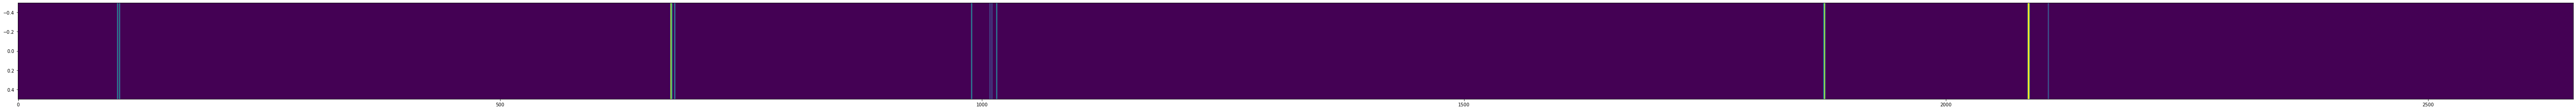

In [156]:
sampleCustomerID = 18177
sampleCustomer_h = np.asarray(customerProductMatrix_h.loc[sampleCustomerID])
sampleCustomer_h = np.reshape(sampleCustomer_h, [1, sampleCustomer_h.shape[0]])
showVector(sampleCustomer_h)

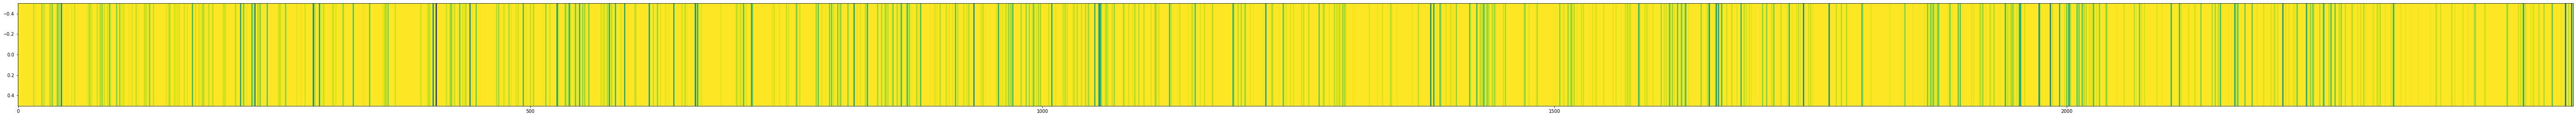

In [157]:
sampleCustomerIndex_h = customerProductMatrix_h.index.get_loc(sampleCustomerID)
distances_h = scipy.spatial.distance.cdist(customerProductMatrix_h, sampleCustomer_h, metric='cosine')
distances_h[sampleCustomerIndex_h][0] = distances_h.mean()
bestMatchingCustomer_h = customerProductMatrix_h[distances_h == distances_h.min()]
bestMatchIndex_h = distances_h.argmin()

showVector(np.reshape(distances_h, [1, distances_h.shape[0]]))

In [158]:
customerProductMatrix_h['Distances'] = distances_h
customerProductMatrix_h = customerProductMatrix_h.sort_values('Distances')
customerProductMatrix_h.head()

StockCode,10080,10120,10125,10133,10135,11001,15030,15034,15036,15039,...,90209B,90209C,90214A,90214K,BANK CHARGES,C2,DOT,M,POST,Distances
CustomerID,,,,,,,,,,,,,,,,,,,,,
13246.0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.418551
18257.0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.526307
18283.0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0.578668
13868.0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.588726
12950.0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.599423


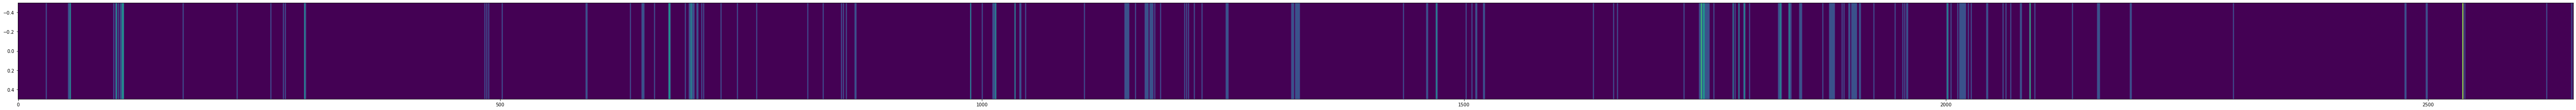

In [159]:
del customerProductMatrix_h['Distances']
bestMatchingCustomers_h = customerProductMatrix_h.head()
bestMatchingCustomerBinaries_h = np.where(bestMatchingCustomers_h > 0, 1, 0)
consensus_h = np.expand_dims(np.sum(bestMatchingCustomerBinaries_h, axis=0), 0)
consensus_h[sampleCustomer_h > 0] = 0
showVector(consensus_h)

In [160]:
customerProductMatrix_h.loc['Rank'] = np.squeeze(consensus_h, 0)
customerProductMatrix_h = customerProductMatrix_h.T.sort_values('Rank', ascending=False)
recommendedProducts_h = customerProductMatrix_h[customerProductMatrix_h['Rank'] > 0]
recommendedProducts_h

CustomerID,13246.0,18257.0,18283.0,13868.0,12950.0,12808.0,16999.0,17031.0,16458.0,13238.0,...,14658.0,14657.0,14653.0,14652.0,14651.0,14644.0,14640.0,14696.0,18287.0,Rank
StockCode,,,,,,,,,,,,,,,,,,,,,
85099B,0,10,8,10,130,0,0,0,80,10,...,0,0,0,0,0,0,0,0,0,4
23201,1,0,5,0,120,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,3
23583,0,10,7,10,0,10,0,0,30,0,...,0,0,0,0,0,0,0,0,0,3
22411,0,0,1,0,120,0,0,0,0,10,...,0,0,0,0,0,0,0,0,0,2
23493,0,10,1,0,0,10,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23404,2,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,1
23518,0,6,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
21874,0,0,8,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [161]:
recommendedProducts_h = [recommendedProducts_h['Rank']]
recommendedProducts_h = pd.DataFrame(recommendedProducts_h).T
recommendedProductsTop_h = recommendedProducts_h.head(10)
recommendedProductsTop_h

,Rank
StockCode,
85099B,4
23201,3
23583,3
22411,2
23493,2
21977,2
23247,2
20718,2
17012F,2


In [162]:
HighSeason.loc[HighSeason['StockCode'].isin(recommendedProductsTop_h.index.tolist())]['Description'].unique()

array(['JUMBO BAG RED RETROSPOT', 'LUNCH BAG  BLACK SKULL.',
       'JUMBO BAG ALPHABET', 'JUMBO SHOPPER VINTAGE RED PAISLEY',
       'RED RETROSPOT SHOPPER BAG', "BISCUIT TIN 50'S CHRISTMAS",
       'PACK OF 60 PINK PAISLEY CAKE CASES',
       'ORIGAMI SANDLEWOOD INCENSE/CAND SET',
       'VINTAGE DOILY TRAVEL SEWING KIT', 'LUNCH BAG PAISLEY PARK  '],
      dtype=object)

In [163]:
HighSeason.loc[HighSeason['CustomerID'] == sampleCustomerID]['Description']

449507         BLACK CHRISTMAS TREE 120CM
449508       VINTAGE DOILY JUMBO BAG RED 
449509             JUMBO BAG PAISLEY PARK
449510           RECYCLING BAG RETROSPOT 
449511            JUMBO BAG PINK POLKADOT
449512       JUMBO BAG VINTAGE CHRISTMAS 
449513          JUMBO BAG 50'S CHRISTMAS 
449514    SCANDINAVIAN PAISLEY PICNIC BAG
449515    PINK VINTAGE PAISLEY PICNIC BAG
449516        RED RETROSPOT CHARLOTTE BAG
449517        CHARLOTTE BAG PINK POLKADOT
449518           RED RETROSPOT PICNIC BAG
449519             TOY TIDY PINK POLKADOT
449520             WOODLAND CHARLOTTE BAG
Name: Description, dtype: object

### --------------------------------------------------------------------------------------------------------------------------------------------------------------

## <span style='color:green'> EXAMPLE FROM THE CLASS GIVEN BY DAVID - RECOMMENDATION SYSTEM </span>

### <span style='color:teal'> LOW SEASON </span>

# Train-test split
We want to split the train and test events such that:
- all test events occur after all train events

In [164]:
# How many weeks does the dataset has?
data = pd.DatetimeIndex(LowSeason['InvoiceDate']).normalize().value_counts().sort_index()
diff = (data.index.max() - data.index.min())
print(f"The dataset has {diff.days} days, corresponding to {diff.days//7} weeks.")

The dataset has 273 days, corresponding to 39 weeks.


In [165]:
# Train-test split
start_train = LowSeason['InvoiceDate'].min()
start_test = start_train + pd.to_timedelta(29, unit='w')
end_test = start_test + pd.to_timedelta(11, unit='w')

# Create new limited df
LowSeason = LowSeason.loc[(LowSeason['InvoiceDate'] > start_train) & (LowSeason['InvoiceDate'] <= end_test)]

# Create train_split flag
LowSeason['train_split'] = (LowSeason['InvoiceDate'] <= start_test).astype(int)
print("Proportion of train events: {:.2f}".format(LowSeason['train_split'].mean()))



Proportion of train events: 0.73


<ipython-input-165-e314350b2af9>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  LowSeason['train_split'] = (LowSeason['InvoiceDate'] <= start_test).astype(int)


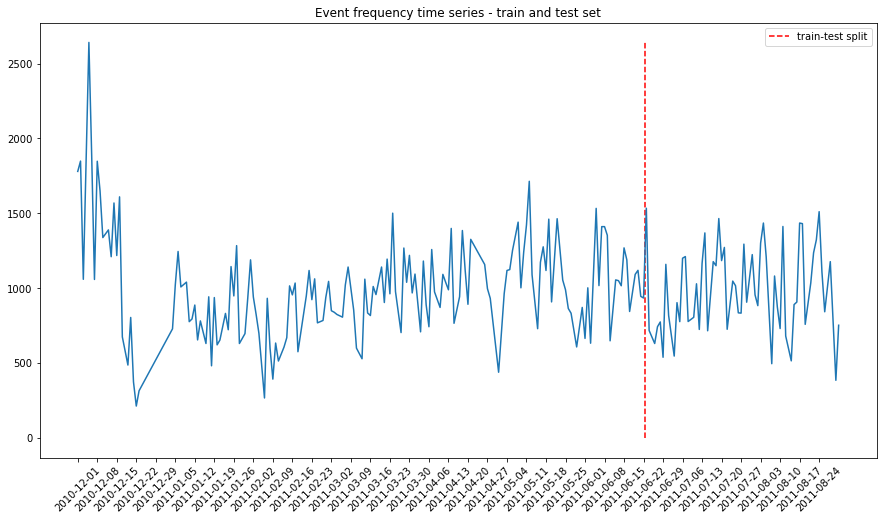

In [166]:
# Visualize train and test set
data = pd.DatetimeIndex(LowSeason['InvoiceDate']).normalize().value_counts().sort_index()
fig = plt.figure(figsize=(15,8))
plt.plot(data.index, data.values, linestyle="-")
plt.xticks(np.arange(data.index[0], data.index[-1], pd.to_timedelta(7, unit='d')), rotation=45)
plt.vlines(start_test, 0, data.max(), linestyles='dashed', color='r', label='train-test split')
plt.legend()
plt.title('Event frequency time series - train and test set')
plt.show()

# Create the train and test Rating Matrices

<img src="./images/MaskTrain.png" alt="MaskTrain" style="width: 600px;"/>

In [167]:
# the Categoricals data structure consists of a categories array and an integer array of codes which point to 
#    the real value in the categories array
user_cat = LowSeason['CustomerID'].astype('category')
item_cat =  LowSeason['StockCode'].astype("category")

# create a sparse matrix of all the item/user/counts triples for the train set and test set
# https://docs.scipy.org/doc/scipy/reference/generated/scipy.sparse.coo_matrix.html#scipy.sparse.coo_matrix
item_user_train = coo_matrix(( LowSeason['train_split'],
                              (item_cat.cat.codes,
                               user_cat.cat.codes))).tocsr()
item_user_train.eliminate_zeros()  # remove zero entries
# produce transpose of item_user_train
user_item_train = item_user_train.T

item_user_test = coo_matrix(((~ LowSeason['train_split'].astype(bool)).astype(int),
                             (item_cat.cat.codes,
                              user_cat.cat.codes))).tocsr()
item_user_test.eliminate_zeros()  # remove zero entries
# produce transpose of item_user_test
user_item_test = item_user_test.T

# map each item and user category to a unique numeric code
user_map = dict(zip(user_cat, user_cat.cat.codes))
item_map = dict(zip(item_cat, item_cat.cat.codes))

def get_keys(value, dictionary):
    """Function to get dictionary keys with specifiec value"""
    return list(dictionary.keys())[list(dictionary.values()).index(value)]

# confirm shapes
print(f"train set shape: {item_user_train.shape} and test set shape: {item_user_test.shape}")

# check sparsity
pzeros_train = 100 * (1 - item_user_train.count_nonzero() / (item_user_train.shape[0] * item_user_train.shape[1]))
pzeros_test = 100 * (1 - item_user_test.count_nonzero() / (item_user_test.shape[0] * item_user_test.shape[1]))
print(f"train set percentage of zeros: {pzeros_train} and test set percentage of zeros: {pzeros_test}")

train set shape: (2671, 2602) and test set shape: (2671, 2602)
train set percentage of zeros: 98.2704459979666 and test set percentage of zeros: 99.2649003401755


In [168]:
train = LowSeason.loc[LowSeason['train_split']==1]

In [169]:
# Number of unique invoices in the train set
train['InvoiceNo'].nunique()

7674

In [170]:
# Number of customers in the train set
train['CustomerID'].nunique()

2318

In [171]:
test = LowSeason.loc[LowSeason['train_split']==0]

In [172]:
# Number of unique invoices in the test set
test['InvoiceNo'].nunique()

2775

In [173]:
# Number of customers in the test set
test['CustomerID'].nunique()

1439

In [174]:
df_limited['CustomerID'].nunique()

3271

In [175]:
# users with no items on the train set and not items on the test set
zero_users_test = (np.squeeze(np.asarray(user_item_test.sum(axis=1))) == 0).nonzero()[0]
zero_users_train = (np.squeeze(np.asarray(user_item_train.sum(axis=1))) == 0).nonzero()[0]
set(zero_users_test).intersection(zero_users_train)

set()

In [176]:
# most frequent user, item pair in train set
item_id, user_id = np.unravel_index(item_user_train.argmax(), item_user_train.shape)
item_id, user_id = get_keys(item_id, item_map), get_keys(user_id, user_map)
LowSeason.loc[(LowSeason['CustomerID'] == user_id) & (LowSeason['StockCode'] == item_id) & (LowSeason['train_split'] == 1)]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Revenue,train_split
1423,536540,C2,CARRIAGE,1,2010-12-01 14:05:00,50.0,14911,EIRE,50.0,1
12119,537368,C2,CARRIAGE,1,2010-12-06 12:40:00,50.0,14911,EIRE,50.0,1
12452,537378,C2,CARRIAGE,1,2010-12-06 13:06:00,50.0,14911,EIRE,50.0,1
37644,539473,C2,CARRIAGE,1,2010-12-19 14:24:00,50.0,14911,EIRE,50.0,1
42332,539984,C2,CARRIAGE,1,2010-12-23 14:58:00,50.0,14911,EIRE,50.0,1
50141,540547,C2,CARRIAGE,1,2011-01-09 16:07:00,50.0,14911,EIRE,50.0,1
61634,541434,C2,CARRIAGE,1,2011-01-18 10:22:00,50.0,14911,EIRE,50.0,1
69721,541979,C2,CARRIAGE,1,2011-01-24 14:54:00,50.0,14911,EIRE,50.0,1
73067,542278,C2,CARRIAGE,1,2011-01-27 10:43:00,50.0,14911,EIRE,50.0,1
81820,543178,C2,CARRIAGE,1,2011-02-04 10:31:00,50.0,14911,EIRE,50.0,1


# Fit the ALS model
<img src="./images/Tables.png" alt="Tables" style="width: 1000px;"/>


<img src="./images/ALS_Image_Test.png" alt="MaskTrain" style="width: 600px;"/>


Each (user, item) pair is represented initially through a Ranking matrix, which is used to create a Preference matrix and a Confidence matrix. These give information on whether a user likes an item or not and how confident we are of of the preference values, respectively.

The classical latent factor model is induced by the SVD of the user-item observations matrix that associates each user with a user-factors vector and each item with an item-factors vector. The recommendation score between a user and a item is obtained by taking the inner product between the corresponding user-factors and the item-factors vector. The objective function is based on a least-squares with L2 regularization and this function is minimized using SGD.

The ALS model for implicit feedback data also finds the user-factors and the item-factors vectors by factoring the Preference Matrix. The objective function has two main differences: it accounts for the varying confidence levels (using the Confidence matrix) and it accounts for all possible user/item pairs (note the summation indexes) rather than only those corresponding to observed data (if a user did not consumed a certain item it might be because the user dislikes the item or just because the user did not know about the item). The ALS model objective function is provided below:

<img src="./images/equation.png" alt="MaskTrain" style="width: 600px;"/>

The huge number of terms (m users x n items) in the objective function prevents most direct optimization techniques such as SGD. An alternating-least-squares (ALS) optimization process (ALS) is used instead.

In [177]:
# initialize a model

# alpha = 40  
# als_model = AlternatingLeastSquares(factors=200, regularization=0.01, iterations=30, random_state=0)
alpha = 5  # as we observe more evidence for positive preference, our confidence in pui = 1 increases according to alpha (rate of increase)
als_model = AlternatingLeastSquares(factors=50, regularization=0.4, iterations=30, random_state=0)

# train the model on a sparse matrix of item/user/confidence weights
# os.environ['MKL_NUM_THREADS'] = '1'
# os.environ['OPENBLAS_NUM_THREADS'] = '1'
# about the alpha hyperparameter: https://github.com/benfred/implicit/issues/199#issuecomment-490350326
als_model.fit((item_user_train * alpha).astype('double'))

# ALS model methods

In [178]:
# recommend items for a user. 
# the recommended items have the largest inner product with the user vector
user_id = list(user_map.keys())[0]
recommendations = als_model.recommend(user_map[user_id], user_item_train)
list(map(lambda x: (get_keys(x[0], item_map), x[1]), recommendations))

[('22834', 1.3287789),
 ('82482', 1.0382009),
 ('22837', 1.0364988),
 ('22111', 1.0227946),
 ('22867', 1.018717),
 ('85123A', 1.0163376),
 ('84029G', 0.9992172),
 ('82494L', 0.9920612),
 ('82483', 0.9827627),
 ('82486', 0.9782976)]

In [179]:
# find related items
# the related items have the largest inner product with the item vector
item_id = list(item_map.keys())[0]
related = als_model.similar_items(item_map[item_id])
list(map(lambda x: (get_keys(x[0], item_map), x[1]), related))

[('22633', 1.0000001),
 ('22632', 0.87409073),
 ('22867', 0.8669021),
 ('22865', 0.85292065),
 ('22866', 0.8490509),
 ('84029E', 0.59586394),
 ('22941', 0.56678146),
 ('22834', 0.56115973),
 ('22114', 0.5365698),
 ('21479', 0.51639783)]

In [180]:
# show the top 10 items that explain the recommended item to the user
# It is possible to write the LVM as a linear function between preferences and past actions.
# We can then see what are the actions associated with the highest contributions to the given recommendation.
score, contributions, user_weights = als_model.explain(user_map[user_id], 
                                                       user_item_train,
                                                       item_map[item_id])
print("The score of the user/item pair is: ", score)
print("The top N (Description, score) contributions for this user/item pair are:\n", list(map(lambda x: (get_keys(x[0], item_map), x[1]), contributions)))

The score of the user/item pair is:  0.7344067590614375
The top N (Description, score) contributions for this user/item pair are:
 [('22633', 0.2675638008169094), ('22632', 0.19419324189351914), ('84029E', 0.10147482230046913), ('84029G', 0.05858652404732745), ('82483', 0.028084567068143856), ('20679', 0.022544433719643247), ('84406B', 0.018146083264649372), ('22411', 0.01775880735660622), ('21730', 0.017022191444442378), ('22803', 0.016376724685688487)]


# Evaluation
**Note**: We are measuring how well the model will rank the items in the test set for a user, given different items in the training set i.e. **the train and test set have the same users**. We are not making inference for new users that didn't appear in the training set. 

In [181]:
# Baseline: Recommend the most popular items to every user
class PopularRecommender():
    """Baseline Recommender that always suggests the most popular items to every user.
    """
    def fit(self, item_users):
        self.item_id_sort = np.argsort(np.squeeze(np.asarray(item_users.sum(axis=1).reshape(-1))))[::-1]
    
    def recommend(self, userid, user_items, N=10, filter_already_liked_items=None, filter_items=None, recalculate_user=None):
        if filter_already_liked_items != None or filter_items != None or recalculate_user != None:
            raise NotImplementedError("filter_already_liked_items, filter_items and recalculate_user aren't support yet")
        
        return list(zip(self.item_id_sort[:N], range(1, N + 1)))

In [182]:
# Fitting PopularRecommender model
pop_model = PopularRecommender()
pop_model.fit(item_user_train)

In [183]:
# Evaluate models. 
# Precision at K, Mean Average Precision at K, Normalized Discounted Cumulative Gain at K, AUC at K
eval_models = {'pop_model': pop_model, 'als_model': als_model}
eval_table = {}
for k, v in eval_models.items():
    eval_table[k] = ranking_metrics_at_k(v, user_item_train, user_item_test, K=100, show_progress=True, num_threads=0)
eval_table = pd.DataFrame(eval_table)
eval_table

,pop_model,als_model
precision,0.222101,0.113793
map,0.045383,0.021969
ndcg,0.174334,0.095094
auc,0.596885,0.542746


### <span style='color:teal'> HIGH SEASON </span>

In [184]:
# How many weeks does the dataset has?
data = pd.DatetimeIndex(HighSeason['InvoiceDate']).normalize().value_counts().sort_index()
diff = (data.index.max() - data.index.min())
print(f"The dataset has {diff.days} days, corresponding to {diff.days//7} weeks.")

The dataset has 99 days, corresponding to 14 weeks.


In [185]:
# Train-test split
start_train = HighSeason['InvoiceDate'].min()
start_test = start_train + pd.to_timedelta(8, unit='w')
end_test = start_test + pd.to_timedelta(7, unit='w')

# Create new limited df
HighSeason = HighSeason.loc[(HighSeason['InvoiceDate'] > start_train) & (HighSeason['InvoiceDate'] <= end_test)]

# Create train_split flag
HighSeason['train_split'] = (HighSeason['InvoiceDate'] <= start_test).astype(int)
print("Proportion of train events: {:.2f}".format(HighSeason['train_split'].mean()))

Proportion of train events: 0.47


<ipython-input-185-950a958805a3>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  HighSeason['train_split'] = (HighSeason['InvoiceDate'] <= start_test).astype(int)


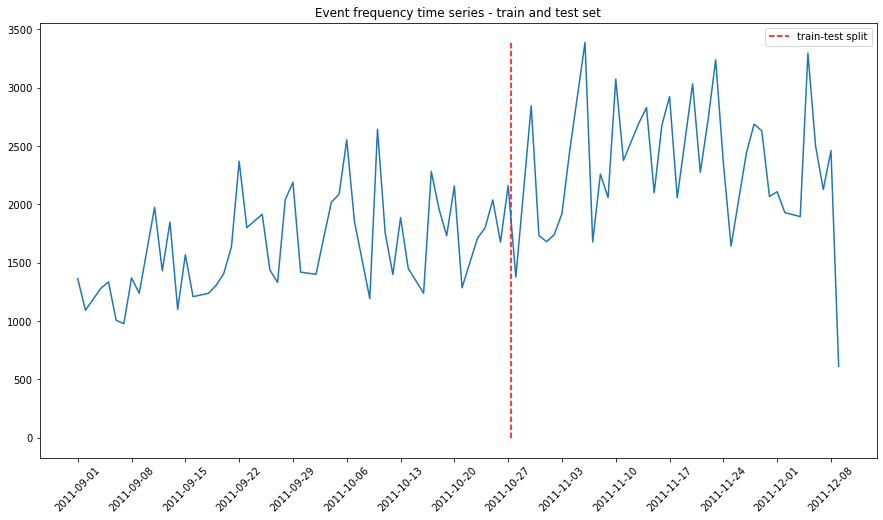

In [186]:
# Visualize train and test set
data = pd.DatetimeIndex(HighSeason['InvoiceDate']).normalize().value_counts().sort_index()
fig = plt.figure(figsize=(15,8))
plt.plot(data.index, data.values, linestyle="-")
plt.xticks(np.arange(data.index[0], data.index[-1], pd.to_timedelta(7, unit='d')), rotation=45)
plt.vlines(start_test, 0, data.max(), linestyles='dashed', color='r', label='train-test split')
plt.legend()
plt.title('Event frequency time series - train and test set')
plt.show()

# Create the train and test Rating Matrices

In [187]:
# the Categoricals data structure consists of a categories array and an integer array of codes which point to 
#    the real value in the categories array
user_cat_high = HighSeason['CustomerID'].astype('category')
item_cat_high =  HighSeason['StockCode'].astype("category")

# create a sparse matrix of all the item/user/counts triples for the train set and test set
# https://docs.scipy.org/doc/scipy/reference/generated/scipy.sparse.coo_matrix.html#scipy.sparse.coo_matrix
item_user_train_h = coo_matrix(( HighSeason['train_split'],
                              (item_cat_high.cat.codes,
                               user_cat_high.cat.codes))).tocsr()
item_user_train_h.eliminate_zeros()  # remove zero entries
# produce transpose of item_user_train
user_item_train_h = item_user_train_h.T

item_user_test_h = coo_matrix(((~ HighSeason['train_split'].astype(bool)).astype(int),
                             (item_cat_high.cat.codes,
                              user_cat_high.cat.codes))).tocsr()
item_user_test_h.eliminate_zeros()  # remove zero entries
# produce transpose of item_user_test
user_item_test_h = item_user_test_h.T

# map each item and user category to a unique numeric code
user_map_h = dict(zip(user_cat_high, user_cat_high.cat.codes))
item_map_h = dict(zip(item_cat_high, item_cat_high.cat.codes))

def get_keys(value, dictionary):
    """Function to get dictionary keys with specifiec value"""
    return list(dictionary.keys())[list(dictionary.values()).index(value)]

# confirm shapes
print(f"train set shape: {item_user_train_h.shape} and test set shape: {item_user_test_h.shape}")

# check sparsity
pzeros_train_h = 100 * (1 - item_user_train_h.count_nonzero() / (item_user_train_h.shape[0] * item_user_train_h.shape[1]))
pzeros_test_h = 100 * (1 - item_user_test_h.count_nonzero() / (item_user_test_h.shape[0] * item_user_test_h.shape[1]))
print(f"train set percentage of zeros: {pzeros_train_h} and test set percentage of zeros: {pzeros_test_h}")

train set shape: (2651, 2495) and test set shape: (2651, 2495)
train set percentage of zeros: 98.96366100741658 and test set percentage of zeros: 98.91567367099344


In [188]:
train_h = HighSeason.loc[HighSeason['train_split']==1]

In [189]:
# Number of unique invoices in the train set
train_h['InvoiceNo'].nunique()

3051

In [190]:
# Number of customers in the train set
train_h['CustomerID'].nunique()

1760

In [191]:
test_h = HighSeason.loc[HighSeason['train_split']==0]

In [192]:
# Number of unique invoices in the test set
test_h['InvoiceNo'].nunique()

3482

In [193]:
# Number of customers in the test set
test_h['CustomerID'].nunique()

1783

In [194]:
# users with no items on the train set and not items on the test set
zero_users_test_h = (np.squeeze(np.asarray(user_item_test_h.sum(axis=1))) == 0).nonzero()[0]
zero_users_train_h = (np.squeeze(np.asarray(user_item_train_h.sum(axis=1))) == 0).nonzero()[0]
set(zero_users_test_h).intersection(zero_users_train_h)

set()

In [195]:
# most frequent user, item pair in train set
item_id_h, user_id_h = np.unravel_index(item_user_train_h.argmax(), item_user_train_h.shape)
item_id_h, user_id_h = get_keys(item_id_h, item_map_h), get_keys(user_id_h, user_map_h)
HighSeason.loc[(HighSeason['CustomerID'] == user_id_h) & (HighSeason['StockCode'] == item_id_h) & (HighSeason['train_split'] == 1)]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Revenue,train_split
329744,565851,C2,CARRIAGE,1,2011-09-07 13:06:00,50.0,14911,EIRE,50.0,1
341724,566776,C2,CARRIAGE,1,2011-09-15 09:53:00,50.0,14911,EIRE,50.0,1
342202,566846,C2,CARRIAGE,1,2011-09-15 11:54:00,50.0,14911,EIRE,50.0,1
350184,567616,C2,CARRIAGE,1,2011-09-21 12:23:00,50.0,14911,EIRE,50.0,1
353055,567720,C2,CARRIAGE,1,2011-09-22 10:37:00,50.0,14911,EIRE,50.0,1
360310,568221,C2,CARRIAGE,1,2011-09-26 10:05:00,50.0,14911,EIRE,50.0,1
365165,568698,C2,CARRIAGE,1,2011-09-28 14:57:00,50.0,14911,EIRE,50.0,1
365421,568706,C2,CARRIAGE,1,2011-09-28 15:32:00,50.0,14911,EIRE,50.0,1
369433,569028,C2,CARRIAGE,1,2011-09-30 10:20:00,50.0,14911,EIRE,50.0,1
370190,569130,C2,CARRIAGE,1,2011-09-30 13:46:00,50.0,14911,EIRE,50.0,1


# Fit the ALS model

In [196]:
# initialize a model
# alpha = 40  
# als_model = AlternatingLeastSquares(factors=200, regularization=0.01, iterations=30, random_state=0)
alpha = 5  # as we observe more evidence for positive preference, our confidence in pui = 1 increases according to alpha (rate of increase)
als_model = AlternatingLeastSquares(factors=50, regularization=0.4, iterations=30, random_state=0)

# train the model on a sparse matrix of item/user/confidence weights
# os.environ['MKL_NUM_THREADS'] = '1'
# os.environ['OPENBLAS_NUM_THREADS'] = '1'
# about the alpha hyperparameter: https://github.com/benfred/implicit/issues/199#issuecomment-490350326
als_model.fit((item_user_train_h * alpha).astype('double'))

# ALS model methods

In [197]:
# recommend items for a user. 
# the recommended items have the largest inner product with the user vector
user_id_h = list(user_map_h.keys())[0]
recommendations_h = als_model.recommend(user_map_h[user_id_h], user_item_train_h)
list(map(lambda x: (get_keys(x[0], item_map_h), x[1]), recommendations_h))

[('23263', 0.7495862),
 ('22423', 0.6792297),
 ('23265', 0.639998),
 ('23266', 0.6318047),
 ('23247', 0.6128408),
 ('23264', 0.61064696),
 ('23245', 0.57657444),
 ('23311', 0.5752846),
 ('22147', 0.49941632),
 ('23234', 0.45921612)]

In [198]:
# find related items
# the related items have the largest inner product with the item vector
item_id_h = list(item_map_h.keys())[0]
related_h = als_model.similar_items(item_map_h[item_id_h])
list(map(lambda x: (get_keys(x[0], item_map_h), x[1]), related_h))

[('22423', 1.0000001),
 ('23245', 0.7126749),
 ('23173', 0.7067352),
 ('22699', 0.69504565),
 ('22697', 0.68595123),
 ('22698', 0.6733832),
 ('23170', 0.66721004),
 ('23171', 0.5987033),
 ('23174', 0.5942595),
 ('23175', 0.5826615)]

In [199]:
# show the top 10 items that explain the recommended item to the user
# It is possible to write the LVM as a linear function between preferences and past actions.
# We can then see what are the actions associated with the highest contributions to the given recommendation.
score_h, contributions_h, user_weights_h = als_model.explain(user_map_h[user_id_h], 
                                                       user_item_train_h,
                                                       item_map_h[item_id_h])
print("The score of the user/item pair is: ", score_h)
print("The top N (Description, score) contributions for this user/item pair are:\n", list(map(lambda x: (get_keys(x[0], item_map_h), x[1]), contributions_h)))

The score of the user/item pair is:  0.24724982429628753
The top N (Description, score) contributions for this user/item pair are:
 [('22423', 0.12381891043088832), ('23245', 0.07242601823510761), ('23311', 0.019616318196464238), ('23432', 0.017292584185716567), ('22741', 0.016683497466419256), ('15060B', 0.009340289732943185), ('21523', 0.007173476619152075), ('85061W', 0.004017495605495984), ('23234', 0.003849274143584938), ('22147', 0.0026971223013441746)]


# Evaluation
**Note**: We are measuring how well the model will rank the items in the test set for a user, given different items in the training set i.e. **the train and test set have the same users**. We are not making inference for new users that didn't appear in the training set. 

In [200]:
# Fitting PopularRecommender model
pop_model_h = PopularRecommender()
pop_model_h.fit(item_user_train_h)

In [201]:
# Evaluate models. 
# Precision at K, Mean Average Precision at K, Normalized Discounted Cumulative Gain at K, AUC at K
eval_models_h = {'pop_model_HighSeason': pop_model_h, 'als_model_HighSeason': als_model}
eval_table_h = {}
for k, v in eval_models_h.items():
    eval_table_h[k] = ranking_metrics_at_k(v, user_item_train_h, user_item_test_h, K=100, show_progress=True, num_threads=0)
eval_table_h = pd.DataFrame(eval_table_h)
eval_table_h

,pop_model_HighSeason,als_model_HighSeason
precision,0.215587,0.105367
map,0.041413,0.021674
ndcg,0.166593,0.086946
auc,0.593878,0.534094
